# Blood MSEPM Model

- Workflow for generating aggregate MSEPM blood model

## Notebook setup

- R Software Versions (R 4.1.2)
    - LOLA_1.24.0                               
    - FlowSorted.Blood.450k_1.32.0              
    - IlluminaHumanMethylation450kmanifest_0.4.0
    - minfi_1.40.0                              
    - bumphunter_1.36.0                         
    - locfit_1.5-9.6                            
    - iterators_1.0.14                          
    - foreach_1.5.2                             
    - Biostrings_2.62.0                         
    - XVector_0.34.0                            
    - SummarizedExperiment_1.24.0               
    - Biobase_2.54.0                            
    - MatrixGenerics_1.6.0                      
    - matrixStats_0.62.0                        
    - GenomicRanges_1.46.1                      
    - GenomeInfoDb_1.30.1                       
    - IRanges_2.28.0                            
    - S4Vectors_0.32.4                          
    - BiocGenerics_0.40.0 

In [1]:
%load_ext rpy2.ipython

In [2]:
import bisect
from collections import defaultdict, Counter
from functools import reduce
import gzip
import io
from itertools import cycle
import math
import os
import pkg_resources
import pickle
import random
import sys
from typing import Dict, List, Set, Tuple, Union

from msepm import MultistateEpigeneticPacemaker, MultistateEpigeneticPacemakerCV
from msepm.helpers import pearson_correlation
from msepm.scaler import Scaler
from MethAnalysisHelpers.DataHandlers import retrieve_sample_methylation, get_normalization_ref
from MethAnalysisHelpers.QuantileNormalization import QuantileNormalizeSample
from MethAnalysisHelpers.ModelHelpers import basic_func, fit_trend, get_age_bins, mae, r2
from MethAnalysisHelpers.Plots import plot_known_predicted

from IPython.display import display, Markdown, Latex, HTML
import joblib
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib import cm, rc
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import cluster
from scipy import spatial
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

In [3]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [4]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

In [5]:
display(HTML(pd.DataFrame(session_info, index=['Package', 'Version']).T.to_html()))

### Set Plot Characteristics

In [6]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.usetex'] = False

## Import Array Experiments

In [7]:
wd = os.path.abspath(os.path.join(os.getcwd(), '..'))

In [8]:
lola_db = os.path.join(wd, 'DataProcessing/loladb')

In [9]:
with open(os.path.join(wd, 'DataProcessing/ProcessedData/processed_sample_meta.pkl'), 'rb') as meta:
    sample_meta = pickle.load(meta)

In [10]:
k_ref = get_normalization_ref()

In [11]:
blood_450k_fit = np.poly1d(np.array([0.6673252 , 3.71840352]))

In [12]:
def sample_check(info, platform_id='GPL13534', tissue='blood', 
                 relative_intensity_filter=None,
                 med_res_max = 0.4, 
                 test_exps={}):
    uMed_res_check = True
    if relative_intensity_filter:
        uMed_res_check = abs(info['proc_uMed'] - relative_intensity_filter(info['proc_mMed'])) < med_res_max
    check = [info['platform_id'] == platform_id, not info['proc_qc_fail'],
             info['proc_tissue'] == tissue, 'age yrs' in info,
             info['experiment_id'] not in test_exps, uMed_res_check]
    return all(check)

In [13]:
test_exps = {'GSE111629', 'GSE61496', 'GSE43976', 'GSE87640', 'GSE69138', 'GSE121633', 
                'GSE51032', 'GSE111165', 'GSE156994', 'GSE125105', 'GSE142512', 
                   'GSE87648', 'GSE73103', 'GSE59065', 'GSE51057', 'GSE128235'}

In [14]:
blood_meta = {sample: info for sample, info in sample_meta.items() if 
              sample_check(info, relative_intensity_filter=blood_450k_fit) }

In [15]:
blood_df = pd.DataFrame(blood_meta).T

In [16]:
modeling_samples = np.array([key for key, value in blood_meta.items() if value['experiment_id'] not in test_exps])

In [17]:
test_samples = np.array([key for key, value in blood_meta.items() if value['experiment_id'] in test_exps])

### Subset Training / Validation Samples

In [18]:
modeling_ages = np.array([blood_meta[sample]['age yrs'] for sample in modeling_samples])

In [19]:
ref_ages = np.array([sample['age yrs'] for sample in blood_meta.values()])

In [20]:
cell_types = ['proc_CD8T', 'proc_CD4T', 'proc_NK',
              'proc_Bcell','proc_Mono', 'proc_Gran']

In [21]:
def merge_bins(bins, min_bin_size=5):
    merged_bins = list(bins)
    while True:
        max_bin = max(merged_bins) - 1
        cleaned_bins = []
        bin_count = Counter(merged_bins)
        all_bins_merged = True
        for sample_bin in merged_bins:
            if bin_count[sample_bin] < min_bin_size:
                all_bins_merged = False
                if sample_bin < max_bin:
                    cleaned_bins.append(sample_bin + 1)
                else:
                    cleaned_bins.append(sample_bin - 1)
            else:
                cleaned_bins.append(sample_bin)
        merged_bins = cleaned_bins
        if all_bins_merged:
            break
    return np.array(merged_bins)       

In [22]:
def get_age_bins(ages, bin_number=20):
    binning = []
    interval = (max(ages) - min(ages)) / bin_number
    bin_ranges = [interval * x for x in range(bin_number)]
    for age in ages:
        binning.append(bisect.bisect_left(bin_ranges, age))
    return merge_bins(binning)

In [23]:
age_bins = get_age_bins(modeling_ages, bin_number=20)

In [24]:
train_indices, test_indices = train_test_split([x for x in range(len(modeling_ages))], stratify=age_bins, random_state=1, train_size=0.75)

In [25]:
train_samples, test_samples = modeling_samples[train_indices], modeling_samples[test_indices]

In [26]:
train_samples_1 = list(train_samples)

## Train Cell Type PCA 

In [27]:
# train PCA using training samples

train_cells = []

for ct in cell_types:
    train_cells.append([blood_meta[sample][ct] for sample in train_samples])

cell_pca = PCA(whiten=True, random_state=1).fit(np.array(train_cells).T)

In [28]:
ref_cells = []

for ct in cell_types:
    ref_cells.append([sample[ct] for sample in blood_meta.values()])

In [29]:
# retrieve cell type PCs for training / validation samples 
cell_pcs = cell_pca.transform(np.array(ref_cells).T)

In [30]:
cell_type_labels = ['CD8 T Cell', 'CD4 T Cell', 'Natural Killer', 'B Cell', 'Monocyte', 'Granulocyte']

In [31]:
loadings = pd.DataFrame(cell_pca.components_, columns=cell_type_labels, 
                        index=[f'PC{x+1}' for x in range(cell_pca.components_.shape[0])])

In [32]:
pc_scaler = Scaler(X_min=np.array([-1,-1]), X_max=np.array([1,1]))

In [33]:
scaled_pcs = pc_scaler.fit_transform(cell_pcs[:,0:2])

In [34]:
blood_df.shape

(5687, 138)

In [35]:
ref_cells_df = pd.DataFrame(np.array(ref_cells), index=cell_type_labels).T

In [36]:
blood_cats = {'Whole blood':'Whole blood', 'wh blood': 'Whole blood',
              'whole blood':'Whole blood', 'case_whole blood': 'Whole blood',
              'control_whole blood': 'Whole blood',
              'PBL': 'PBL', 'Buffy coat': 'Buffy coat',
               'PBMC': 'PBMC', 'stroke blood sample':'Whole blood',
               'whole blood genomic DNA': 'Whole blood', 'DNA from EDTA-stored blood': 'Whole blood'}

In [37]:
blood_exps = {'GSE111629': 'Whole blood', 'GSE61496': 'Buffy Coat', 
                 'GSE59065': 'PBMC', 'GSE128064': 'Whole blood',
              'GSE43976': 'Whole blood'}

In [38]:
blood_types = []

for key, value in blood_df[['tissue_source', 'experiment_id']].T.to_dict().items():
    blood_cat = blood_cats.get(value['tissue_source'].split(',')[0], 0)
    if not blood_cat:
        blood_cat = blood_exps.get(value['experiment_id'], 0)
    blood_types.append(blood_cat)

## Format Metadata

In [39]:
ref_meta = pd.DataFrame(ref_cells, columns=blood_meta.keys(), index=cell_types).T

In [40]:
ref_sex = np.array([sample['proc_predictedSex'] for sample in blood_meta.values()])
ref_sex = np.array([1 if sex == 'F' else 0 for sex in ref_sex])

In [41]:
ref_exps = np.array([sample['experiment_id'] for sample in blood_meta.values()])

In [42]:
ref_meta['Age'] = ref_ages
ref_meta['Sex'] = ref_sex
ref_meta['Exps'] = ref_exps

In [43]:
for pc in range(cell_pcs.shape[1]):
    ref_meta[f'PC{pc + 1}'] = cell_pcs[:,pc]

In [44]:
modeling_traits = ['Age','Sex', 'PC1','PC2']

### Plot Trait Summary Information
    - Trait distributions
    - PC Variance Explained
    - Trait association

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


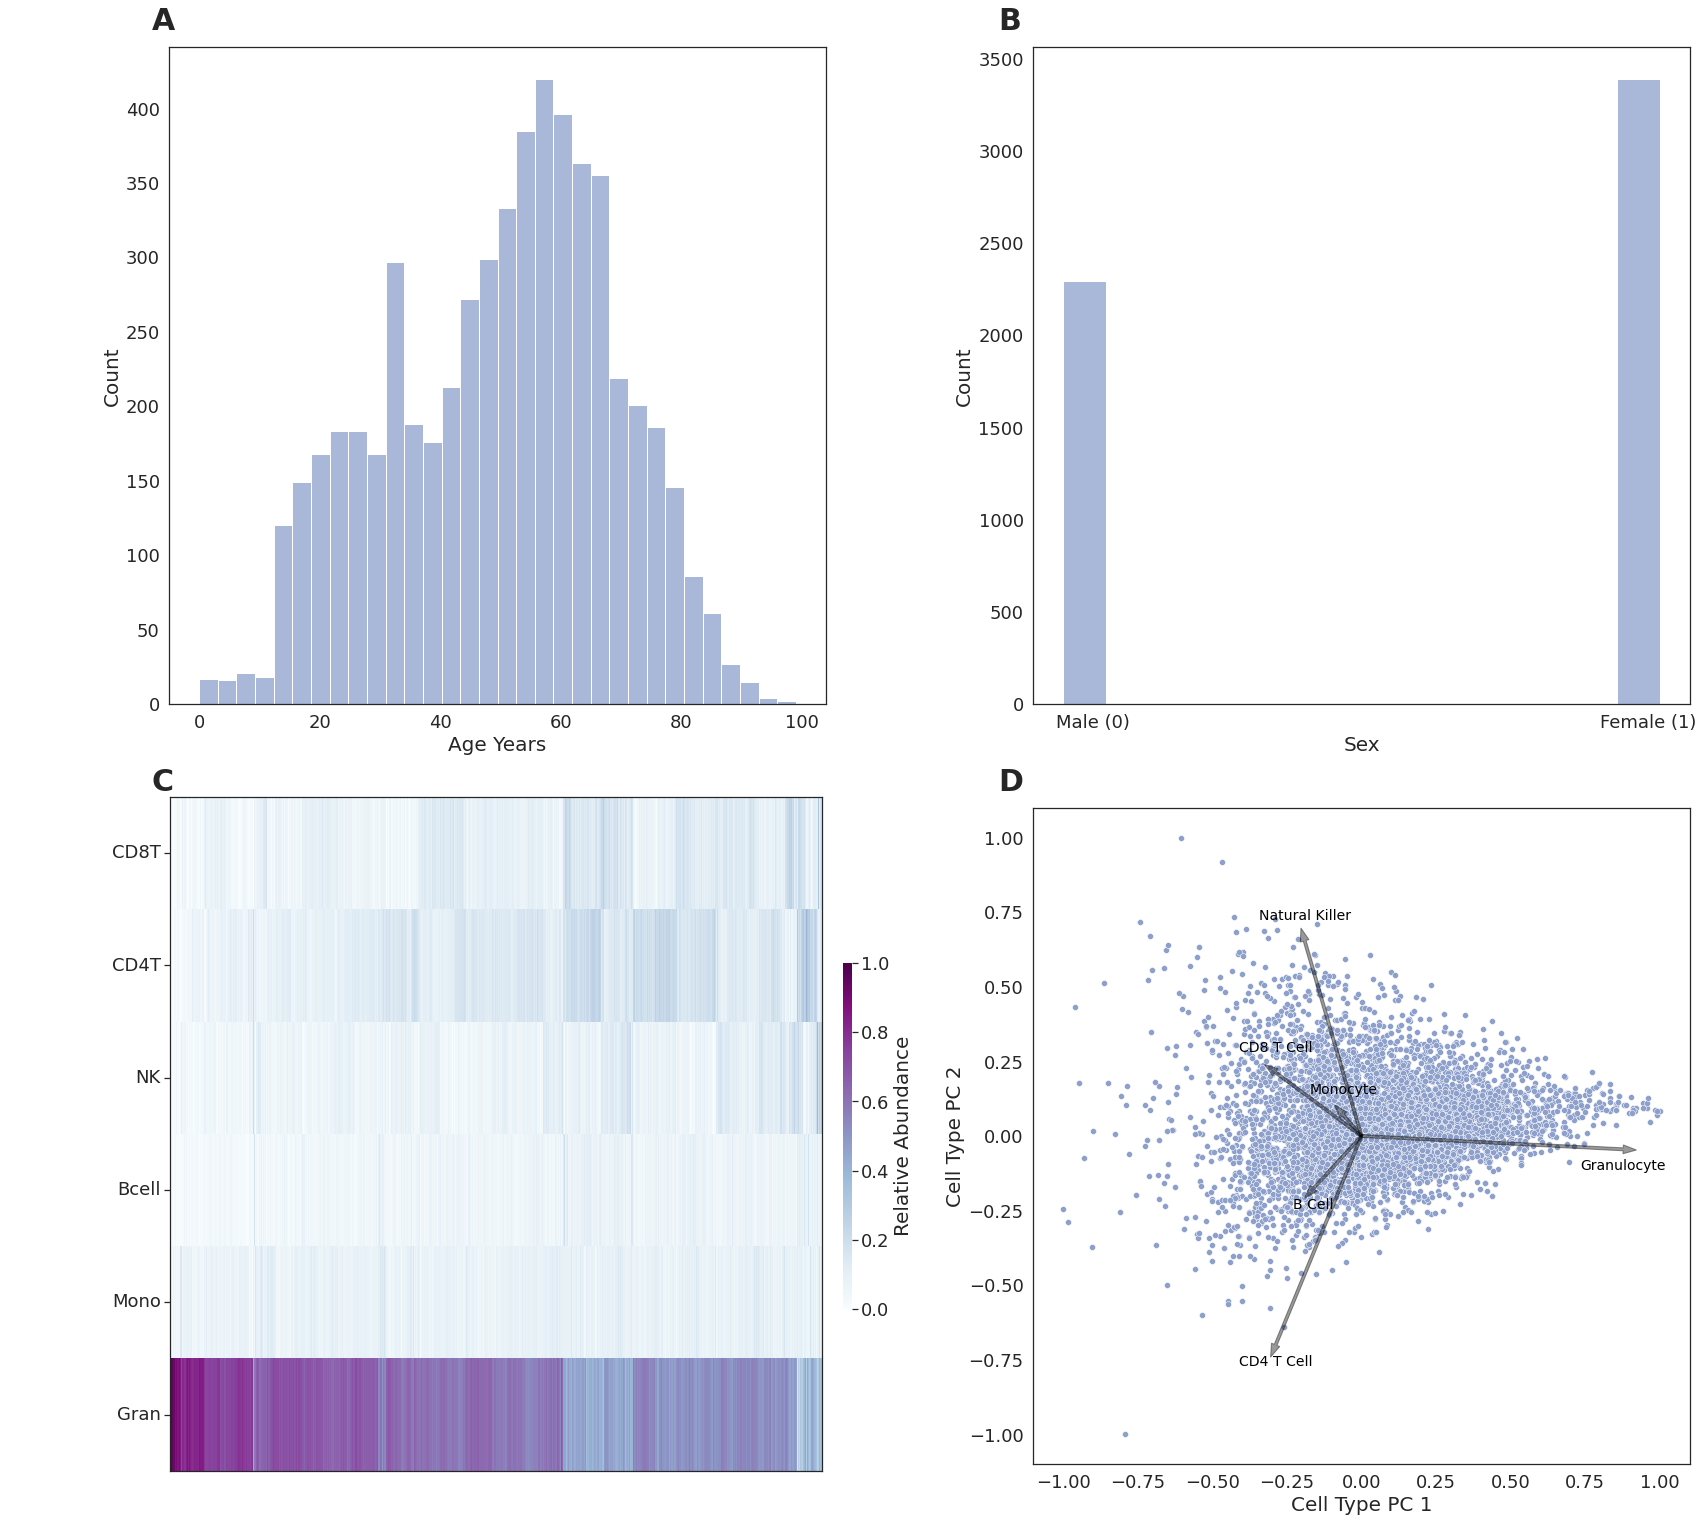

In [45]:
plot = sns.clustermap(ref_meta[['proc_CD8T',
 'proc_CD4T',
 'proc_NK',
 'proc_Bcell',
 'proc_Mono',
 'proc_Gran']].T, row_cluster=False, method='average', metric='euclidean', figsize=(12,12),
                     yticklabels=['CD8T', 'CD4T', 'NK', 'Bcell', 'Mono', 'Gran'], xticklabels=False,
                     cmap="BuPu", vmin=0, vmax=1, cbar_pos=(.98, 0.2, 0.01, 0.4), 
                     cbar_kws=dict(label='Relative Abundance'))

plot.ax_heatmap.yaxis.tick_left()

plt.setp(plot.ax_heatmap.get_yticklabels(), rotation=0)
plot.ax_heatmap.yaxis.set_label_position("left")


for _, spine in plot.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.linewidth = 4

plot.ax_col_dendrogram.set_visible(False)

rel_size = .76

ax = plot.fig.add_axes([1.2, 0.02, rel_size, rel_size])

sns.scatterplot(x=scaled_pcs[:,0], y=scaled_pcs[:,1], ax=ax, c=np.array([sns.color_palette("Set2")[2]]))

x_offset = 0.2
y_offset = 0.07

for ct in list(loadings):
    x, y = loadings[ct].values[0:2]
    ax.arrow(0, 0, x, y,
                color='k', width=0.01, lw=1, alpha=0.4)
    x_sign = -1
    y_sign = -1 if y < 0 else 1
    text_x = x 
    text_y = y + (y_offset * y_sign)
    ax.text(text_x, text_y,
               ct, color='k', size=14, ha='center')
ax.set_ylabel('Cell Type PC 2')
ax.set_xlabel('Cell Type PC 1')


ax = plot.fig.add_axes([.2, .9, rel_size, rel_size])

sns.histplot(ref_meta['Age'], ax=ax, color=np.array([sns.color_palette("Set2")[2]]))
ax.set_xlabel('Age Years')


ax = plot.fig.add_axes([1.2, .9, rel_size, rel_size])

sns.histplot(ref_meta['Sex'], ax=ax, color=np.array([sns.color_palette("Set2")[2]]))
ax.set_xticks([0.05,0.98])
ax.set_xticklabels(['Male (0)', 'Female (1)'])

ax.text(.18, 1.68, 'A', fontsize=30, transform=plt.gcf().transFigure, weight='bold')
ax.text(1.16, 1.68, 'B', fontsize=30, transform=plt.gcf().transFigure, weight='bold')
ax.text(.18, .8, 'C', fontsize=30, transform=plt.gcf().transFigure, weight='bold')
ax.text(1.16, .8, 'D', fontsize=30, transform=plt.gcf().transFigure, weight='bold')

plt.savefig(os.path.join(wd, 'Paper/Figures/Figure3.png'), dpi=200, bbox_inches='tight')

/tmp/ipykernel_80135/227854761.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [f'PC {pc +1}' for pc in range(len(variance_explained))])


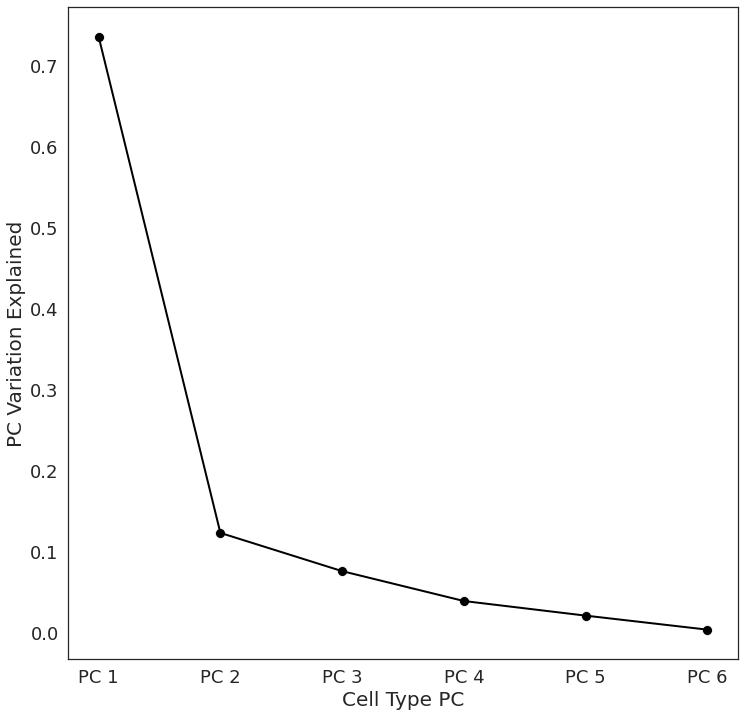

In [46]:
fig, ax = plt.subplots(figsize=(12,12))

variance_explained = cell_pca.explained_variance_ratio_

sns.lineplot(y=variance_explained, x=[pc for pc in range(len(variance_explained))], ax=ax, color='k', lw=2)
sns.scatterplot(y=variance_explained, x=[pc for pc in range(len(variance_explained))], ax=ax, color='k', s=100)
ax.set_xticklabels([''] + [f'PC {pc +1}' for pc in range(len(variance_explained))])
ax.set_ylabel('PC Variation Explained')
ax.set_xlabel('Cell Type PC')

plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure4.png'), bbox_inches='tight', dpi=200)
plt.show()

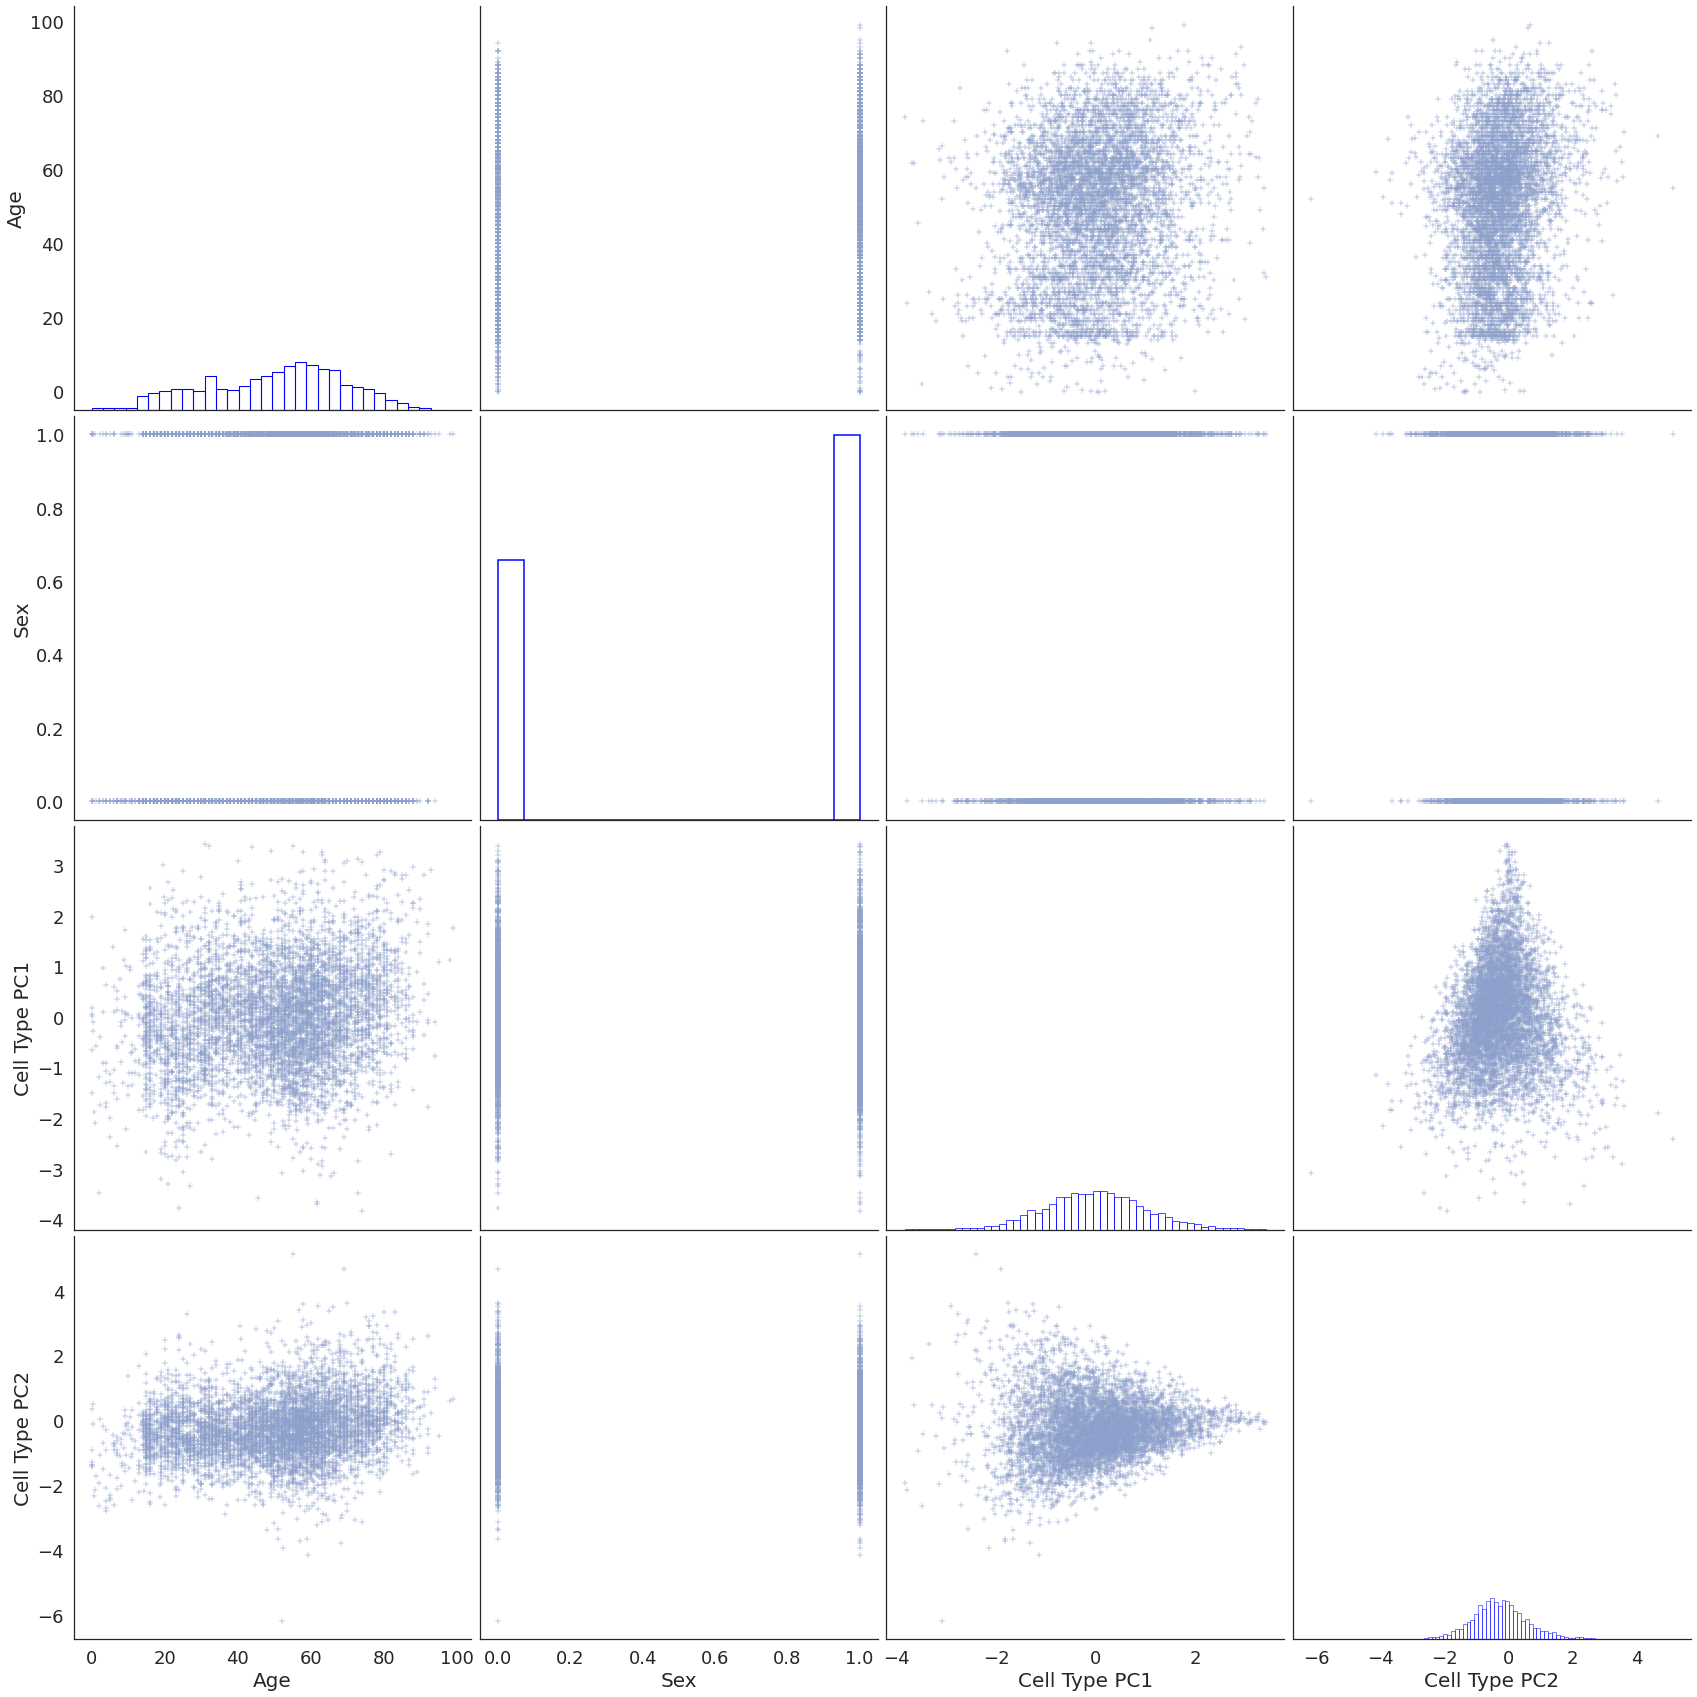

In [47]:
g = sns.pairplot(data=ref_meta[modeling_traits], diag_kind='hist', 
             plot_kws={'color':np.array([sns.color_palette("Set2")[2]]), 'marker':'+'}, diag_kws={'color':'blue', 'fill':False},
             height=6)

for count, label in enumerate(['Age','Sex', 'Cell Type PC1','Cell Type PC2']):
    g.axes[3,count].set_xlabel(label)
    g.axes[count,0].set_ylabel(label)
    
plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure5.png'), bbox_inches='tight', dpi=200)

In [48]:
formatted_ref_meta = ref_meta.copy()
formatted_ref_meta.columns = ['CD8T Rel. Abundance','CD4T Rel. Abundance',
                              'NK Rel. Abundance','Bcell Rel. Abundance',
                              'Mono Rel. Abundance','Gran Rel. Abundance',
                              'Age (Years)','Sex (0-Male, 1-Female)','GEO Series',
                              'Cell Type PC1','Cell Type PC2',
                              'Cell Type PC3','Cell Type PC4',
                              'Cell Type PC5','Cell Type PC6']
formatted_ref_meta.to_csv(os.path.join(wd, 'Paper/SupplementalTables/SupplementalTable2.tsv'), sep='\t',
                          index_label='GEO Sample')

## Load Training Data

In [49]:
for pc in range(cell_pcs.shape[1]):
    ref_meta[f'PC{pc + 1}'] = cell_pcs[:,pc]

In [50]:
processing_dir = os.path.join(wd, 'DataProcessing/ProcessedData/')

In [51]:
def get_sample_matrix_info(sample_meta):
    sample_name = '_'.join(sample_meta["Grn"].split('_')[0:-1])
    file_prefix = f'{sample_meta["experiment_id"]}_{sample_meta["batch"]}'
    return f'\"{sample_name}\"', file_prefix

In [52]:
train_files = [get_sample_matrix_info(blood_meta[sample]) for sample in train_samples]
train_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in train_files}

### Generate Quantile Normalization Reference

In [53]:
if not os.path.exists('norm_ref.pkl'):
    train_methylation, train_header, train_rows = retrieve_sample_methylation(train_files, n_jobs=16, verbosity=10)
    norm_ref = dict(type_1=[], type_2=[])

    vals = {row: val for row, val in zip(train_rows, np.median(train_methylation, axis=1))}

    for probe_type, probes in k_ref.items():
        for pid in probes:
            try:
                norm_ref[probe_type].append(vals[pid])
            except KeyError:
                pass

    norm_ref['type_1'] = np.array(sorted(norm_ref['type_1']))
    norm_ref['type_2'] = np.array(sorted(norm_ref['type_2']))  

    with open('norm_ref.pkl', 'wb') as out:
        pickle.dump(norm_ref, out)

    del vals

else:
    with open('norm_ref.pkl', 'rb') as ref:
        norm_ref = pickle.load(ref)

In [54]:
val_indices = [index for index in range(len(modeling_ages)) if index not in train_indices]

In [55]:
train_samples, val_samples = np.array(modeling_samples)[train_indices], np.array(modeling_samples)[val_indices]

In [56]:
train_files = [get_sample_matrix_info(blood_meta[sample]) for sample in train_samples]
train_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in train_files}

### Load Methylation Training Data

In [57]:
quant = QuantileNormalizeSample(normalization_reference=norm_ref, probe_ids=k_ref)

In [58]:
train_methylation, train_header_o, train_rows = retrieve_sample_methylation(train_files, n_jobs=10, 
                                                                            verbosity=10, quantile_norm=quant)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  15 out of  30 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=10)]: Done  19 out of  30 | elapsed:  2.9min remaining:  1.7min
[Parallel(n_jobs=10)]: Done  23 out of  30 | elapsed:  3.6min remaining:  1.1min
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:  3.9min remaining:   26.1s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:  4.1min finished


In [59]:
train_header = [x.replace('"', '').split('_')[0] for x in train_header_o][1:]

In [60]:
len(train_header)

1203

In [61]:
train_matrix =  pd.DataFrame(train_methylation, columns=train_header, index=train_rows)

In [62]:
train_traits = ref_meta.loc[train_header]

In [63]:
train_ages = np.array([blood_meta[sample]['age yrs'] for sample in list(train_matrix)])

## Train MSEPM

In [64]:
train_modeling = train_traits[modeling_traits]

In [65]:
corr_values = pearson_correlation(train_modeling.values, train_matrix.values)

### Select MSEPM Training Sites

In [66]:
age_sites = np.where(abs(corr_values[0]) > .7)[0]

In [67]:
sex_sites = np.where(abs(corr_values[1]) > .995)[0]

In [68]:
ct1_sites = np.where((abs(corr_values[2]) > .92))[0]
ct2_sites = np.where(abs(corr_values[3]) > .64)[0]

In [69]:
mixed_sites = np.array([count for count, values in enumerate(corr_values.T) if sum(abs(values)) > 1.8])

In [70]:
len(age_sites), len(sex_sites), len(ct1_sites), len(ct2_sites), len(mixed_sites)

(276, 49, 120, 116, 238)

In [71]:
len(age_sites), len(sex_sites), len(ct1_sites), len(ct2_sites), len(mixed_sites)

(276, 49, 120, 116, 238)

In [72]:
sum([len(age_sites), len(sex_sites), len(ct1_sites), len(ct2_sites), len(mixed_sites)])

799

In [73]:
all_sites = mixed_sites

In [74]:
all_sites = reduce(np.union1d, (age_sites, sex_sites, ct1_sites, ct2_sites, mixed_sites))

In [75]:
len(all_sites)

778

In [76]:
all_site_labels = [train_matrix.index[index] for index in all_sites]

In [77]:
epm_matrix = train_matrix.loc[all_site_labels]

In [78]:
site_delta = (epm_matrix.values.max(axis=1) - epm_matrix.values.min(axis=1)).reshape(-1,1)

In [79]:
site_std = epm_matrix.values.std(axis=1)

### Scale training phenotypes

In [80]:
scaler = Scaler(X_min=np.zeros(len(modeling_traits)),
                X_max=np.ones(len(modeling_traits)))

In [81]:
train_pheno_values = scaler.fit_transform(train_modeling.values) 

In [82]:
scaler.X_min[0] = 0.00
scaler.X_max[0] = 100.00

In [83]:
epm_matrix.shape, train_pheno_values.shape

((778, 1203), (1203, 4))

### Model Training

In [84]:
epm_models = {}

for pheno in tqdm(range(train_pheno_values.shape[1])):
    epm = MultistateEpigeneticPacemaker(verbose=False, n_jobs=16, 
                                        learning_rate=0.01, iter_limit=200,
                                        scale_X=False)
    epm.fit(train_pheno_values[:, 0:pheno+1], epm_matrix.values)
    states, predicted_meth = epm.predict(epm_matrix.values, return_site_predictions=True)
    residuals = predicted_meth - epm_matrix.values
    popt, _, expected_a_states = fit_trend(train_pheno_values[:,0], states[:, 0])
    m_r2 = r2(states[:, 0], expected_a_states)
    m_mae = mae(states[:, 0], expected_a_states)
    epm_models[f'epm_{pheno+1}'] = dict(model=epm, states=states, residuals=residuals,
                                        popt=popt, expected_a_states=expected_a_states,
                                        m_mae=m_mae, m_r2=m_r2, train_predicted_meth=predicted_meth)

  0%|          | 0/4 [00:00<?, ?it/s]

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [85]:
def lin_func(x, a, b, c):
    return a * np.asarray(x) + c

In [86]:
fpr, tpr, _ = roc_curve(train_pheno_values[:,1], epm_models['epm_4']['states'][:,1])
train_auc = auc(fpr, tpr)
epm_models['epm_4']['train_fpr'] = fpr 
epm_models['epm_4']['train_tpr'] = tpr 
epm_models['epm_4']['train_auc'] = train_auc 

In [87]:
popt, _, expected_pc1_states = fit_trend(train_pheno_values[:,2], epm_models['epm_4']['states'][:,2], func=lin_func)
epm_models['epm_4']['pc1_popt'] = popt
epm_models['epm_4']['train_pc1_expected'] = expected_pc1_states
epm_models['epm_4']['train_pc1_r2'] = r2(train_pheno_values[:,2], expected_pc1_states)
epm_models['epm_4']['train_pc1_mae'] = mae(train_pheno_values[:,2], expected_pc1_states)

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [88]:
popt, _, expected_pc2_states = fit_trend(train_pheno_values[:,3], epm_models['epm_4']['states'][:,3], func=lin_func)
epm_models['epm_4']['pc2_popt'] = popt
epm_models['epm_4']['train_pc2_expected'] = expected_pc2_states
epm_models['epm_4']['train_pc2_r2'] = r2(train_pheno_values[:,3], expected_pc2_states)
epm_models['epm_4']['train_pc2_mae'] = mae(train_pheno_values[:,3], expected_pc2_states)

In [89]:
auc(fpr, tpr)

1.0

### MSEPM Model Annotation
- Array reference file
    - https://support.illumina.com/downloads/humanmethylation450_15017482_v1-2_product_files.html

In [90]:
site_annotation = {}

with io.BufferedReader(gzip.open(os.path.join(wd, 'DataProcessing/humanmethylation450_15017482_v1-2.csv.gz'), 'rb')) as ref:
    ref_key = {}
    for count, line in tqdm(enumerate(ref)):
        line_split = line.decode().strip().split(',')
        if not ref_key:
            if line_split[0] == 'IlmnID':
                ref_key = {x:y for y,x in enumerate(line_split)}
        else:
            try:
                chrom, pos, strand = (f'chr{line_split[ref_key["CHR"]]}', 
                                      line_split[ref_key['MAPINFO']], 
                                      line_split[ref_key['Strand']])
                if 'rs' not in line_split[ref_key['IlmnID']]:
                    pos = int(pos)
                    strand = '+' if strand == 'F' else '-'
                    site_annotation[line_split[ref_key['IlmnID']]] = (chrom, pos-1, pos, strand)
            except IndexError:
                break

0it [00:00, ?it/s]

In [91]:
site_background = pd.DataFrame(site_annotation).T

In [92]:
site_background.columns = ['Chrom', 'Start', 'End', 'Strand']

### Annotate Full MSEPM Model
- Annotating model sites from full MSEPM model (model trained with all 4 factors)
- Cluster sites
    - Euclidean distance of standardized coefficients
    - Cluster using Ward's method

In [93]:
coef_labels = ['r Age', 'r Sex', 'r CT-PC1', 'r CT-PC2']
standardized_labels = ['r Age / Std', 'r Sex / Std', 'r CT-PC1 / Std', 'r CT-PC2 / Std']

In [94]:
full_model = pd.DataFrame(epm_models['epm_4']['model']._coefs, 
                          columns=coef_labels, 
                          index=all_site_labels)

In [95]:
site_cats = []

for site in all_sites:
    if site in age_sites:
        site_cats.append('Age')
    elif site in sex_sites:
        site_cats.append('Sex')
    elif site in ct1_sites:
        site_cats.append('Cell Type PC1')
    elif site in ct2_sites:
        site_cats.append('Cell Type PC2')
    elif site in mixed_sites:
        site_cats.append('Mixed')
    else:
        site_cats.append('Other')

In [96]:
site_chrom, site_start, site_end, site_strand = [], [], [], []

for site in full_model.index:
    chrom, start, end, strand = site_annotation[site]
    site_chrom.append(chrom)
    site_start.append(start)
    site_end.append(end)
    site_strand.append(strand)
    
full_model['Chrom'] = site_chrom
full_model['Start'] = site_start
full_model['End'] = site_end
full_model['Strand'] = site_strand

In [97]:
full_model['Site Selection Category'] = site_cats
full_model['Site Delta'] = site_delta
full_model['Site Std'] = site_std

In [98]:
full_model[standardized_labels] = full_model[coef_labels].values / full_model['Site Std'].values.reshape(-1,1)

In [99]:
full_model['Intercept'] = epm_models['epm_4']['model']._intercepts

In [100]:
model_sites = list(zip(full_model['Chrom'].values, full_model['Start'].values, full_model['End'].values))

In [101]:
dists = spatial.distance.pdist(full_model[standardized_labels].values, 'euclidean')

In [102]:
coef_linkage = cluster.hierarchy.linkage(dists, method='ward')

In [103]:
clusters = cluster.hierarchy.cut_tree(coef_linkage, height=18).flatten()

In [104]:
full_model['Cluster'] = clusters
full_model['Cluster ID'] = clusters + 1

In [105]:
cluster_labels = sorted(list(set(clusters)))

In [106]:
cluster_colors = plt.cm.get_cmap('tab10', len(cluster_labels)).colors

_colors = []

for clust in clusters:
    _colors.append(cluster_colors[cluster_labels.index(clust)])

In [107]:
handles = [Patch(color) for color in cluster_colors]   

In [108]:
meth_colors = cm.get_cmap('bone_r')(full_model['Intercept'].values)
mean_meth_colors = cm.get_cmap('pink_r')(np.mean(epm_matrix, axis=1))

In [109]:
output_cats = ['Chrom', 'Start', 'End', 'Strand', 
               'Site Selection Category', 'Cluster ID', 
               'Site Delta', 'Site Std', 
               'Intercept', 'r Age', 'r Sex', 'r CT-PC1', 'r CT-PC2', 
               'r Age / Std', 'r Sex / Std', 'r CT-PC1 / Std', 'r CT-PC2 / Std']

In [110]:
full_model[output_cats].to_csv(os.path.join(wd, 'Paper/SupplementalTables/SupplementalTable1.tsv'), sep='\t')

### Model Enrichment Analysis
- Model site enrichment anlaysis using LOLA

In [111]:
%%R
library("LOLA")
library("GenomicRanges")

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.grid, I, unname


R[write to console]: Loading r

In [112]:
%%R -i full_model -i cluster_labels

clust_grs <- list()

for (clust in cluster_labels){
    clust_df = subset(full_model, Cluster == clust)
    clust_gr = makeGRangesFromDataFrame(clust_df,
                                        keep.extra.columns=TRUE,
                                        seqnames.field=c("Chrom"),
                                        start.field=c("Start"),
                                        end.field=c("End"),
                                        strand.field=c("Strand"),
                                        starts.in.df.are.0based=TRUE)
    clust_grs[clust + 1] = clust_gr
}


In [113]:
%%R

cluster_grs = GRangesList(clust_grs)

In [114]:
%%R

full_gr =  makeGRangesFromDataFrame(full_model,
                                    keep.extra.columns=TRUE,
                                    seqnames.field=c("Chrom"),
                                    start.field=c("Start"),
                                    end.field=c("End"),
                                    strand.field=c("Strand"),
                                    starts.in.df.are.0based=TRUE)

In [115]:
%%R -i site_background

universe = makeGRangesFromDataFrame(site_background,
                                    seqnames.field=c("Chrom"),
                                    start.field=c("Start"),
                                    end.field=c("End"),
                                    strand.field=c("Strand"),
                                    starts.in.df.are.0based=TRUE)

In [116]:
%%capture
%%R  -i lola_db

tfdb = list("encode_v4_hg19")

regionDB = loadRegionDB(lola_db, useCache=TRUE, collections=tfdb)

In [117]:
%%R -o locResults

locResults = runLOLA(cluster_grs, universe, regionDB, direction="enrichment")

R[write to console]: Calculating unit set overlaps...

R[write to console]: Calculating universe set overlaps...

R[write to console]: Calculating Fisher scores...



In [118]:
tf_output_columns = ['userSet', 'pValueLog', 'oddsRatio', 'description', 'antibody', 'size', 'support', 'b', 'c', 'd', 'filename']

In [119]:
tf_enrichment_results = locResults[tf_output_columns]
tf_enrichment_results.columns = ['Model Cluster', 'p Value Log', 'Odds Ratio', 'Description', 'Antibody', 'Size', 'Cluster Site - TF Region Overlap (a)', 'TF Region Only (b)', 'Cluster Site Only (c)', 'Assessed Methylation Background (d)', 'ENOCDE File']

In [120]:
#display(Markdown(tf_enrichment_results.to_markdown()))
tf_enrichment_results.to_csv(os.path.join(wd, 'Paper/SupplementalTables/SupplementalTable3.tsv'), sep='\t')

In [121]:
def plot_tf_enrichment(enrichment_df, ax, ranked_tf=10):
    plot_df = enrichment_df.copy()
    plot_df['Antibody'] = [x.split('_')[0] for x in plot_df['antibody'].values]
    a_ranks = []
    for anti in set(plot_df['Antibody'].values):
        try:
            a_rank = np.nanmin(plot_df.loc[plot_df['Antibody'] == anti]['meanRnk'].values)
        except ValueError:
            continue
        a_ranks.append((anti, a_rank))
    _rank = sorted(a_ranks, key= lambda x: x[1], reverse=False)
    plot_antis = [x[0] for x in _rank[:ranked_tf]]
    plot_df = plot_df.loc[plot_df['Antibody'].isin(plot_antis)]
    sns.swarmplot(x='Antibody', y='oddsRatio', dodge=True, ax=ax, data=plot_df,
                  s=10, order=plot_antis)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    #ax.set_ylim([-1,])
    x_labels = [x[0] for x in _rank[:ranked_tf]]
    return x_labels

In [122]:
mean_meth = []

for count, model in enumerate(epm_models.values()):
    plt_x = math.floor(count /3)
    plt_y = count - plt_x * 3
    mean_meth.extend([{'Site MAE':x, 'Modeled Phenotypes':count, 'Site Type': label} for x, label in zip(np.mean(abs(model['residuals']), axis=1), site_cats)])
  

epm_res = pd.DataFrame(mean_meth)

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/ve

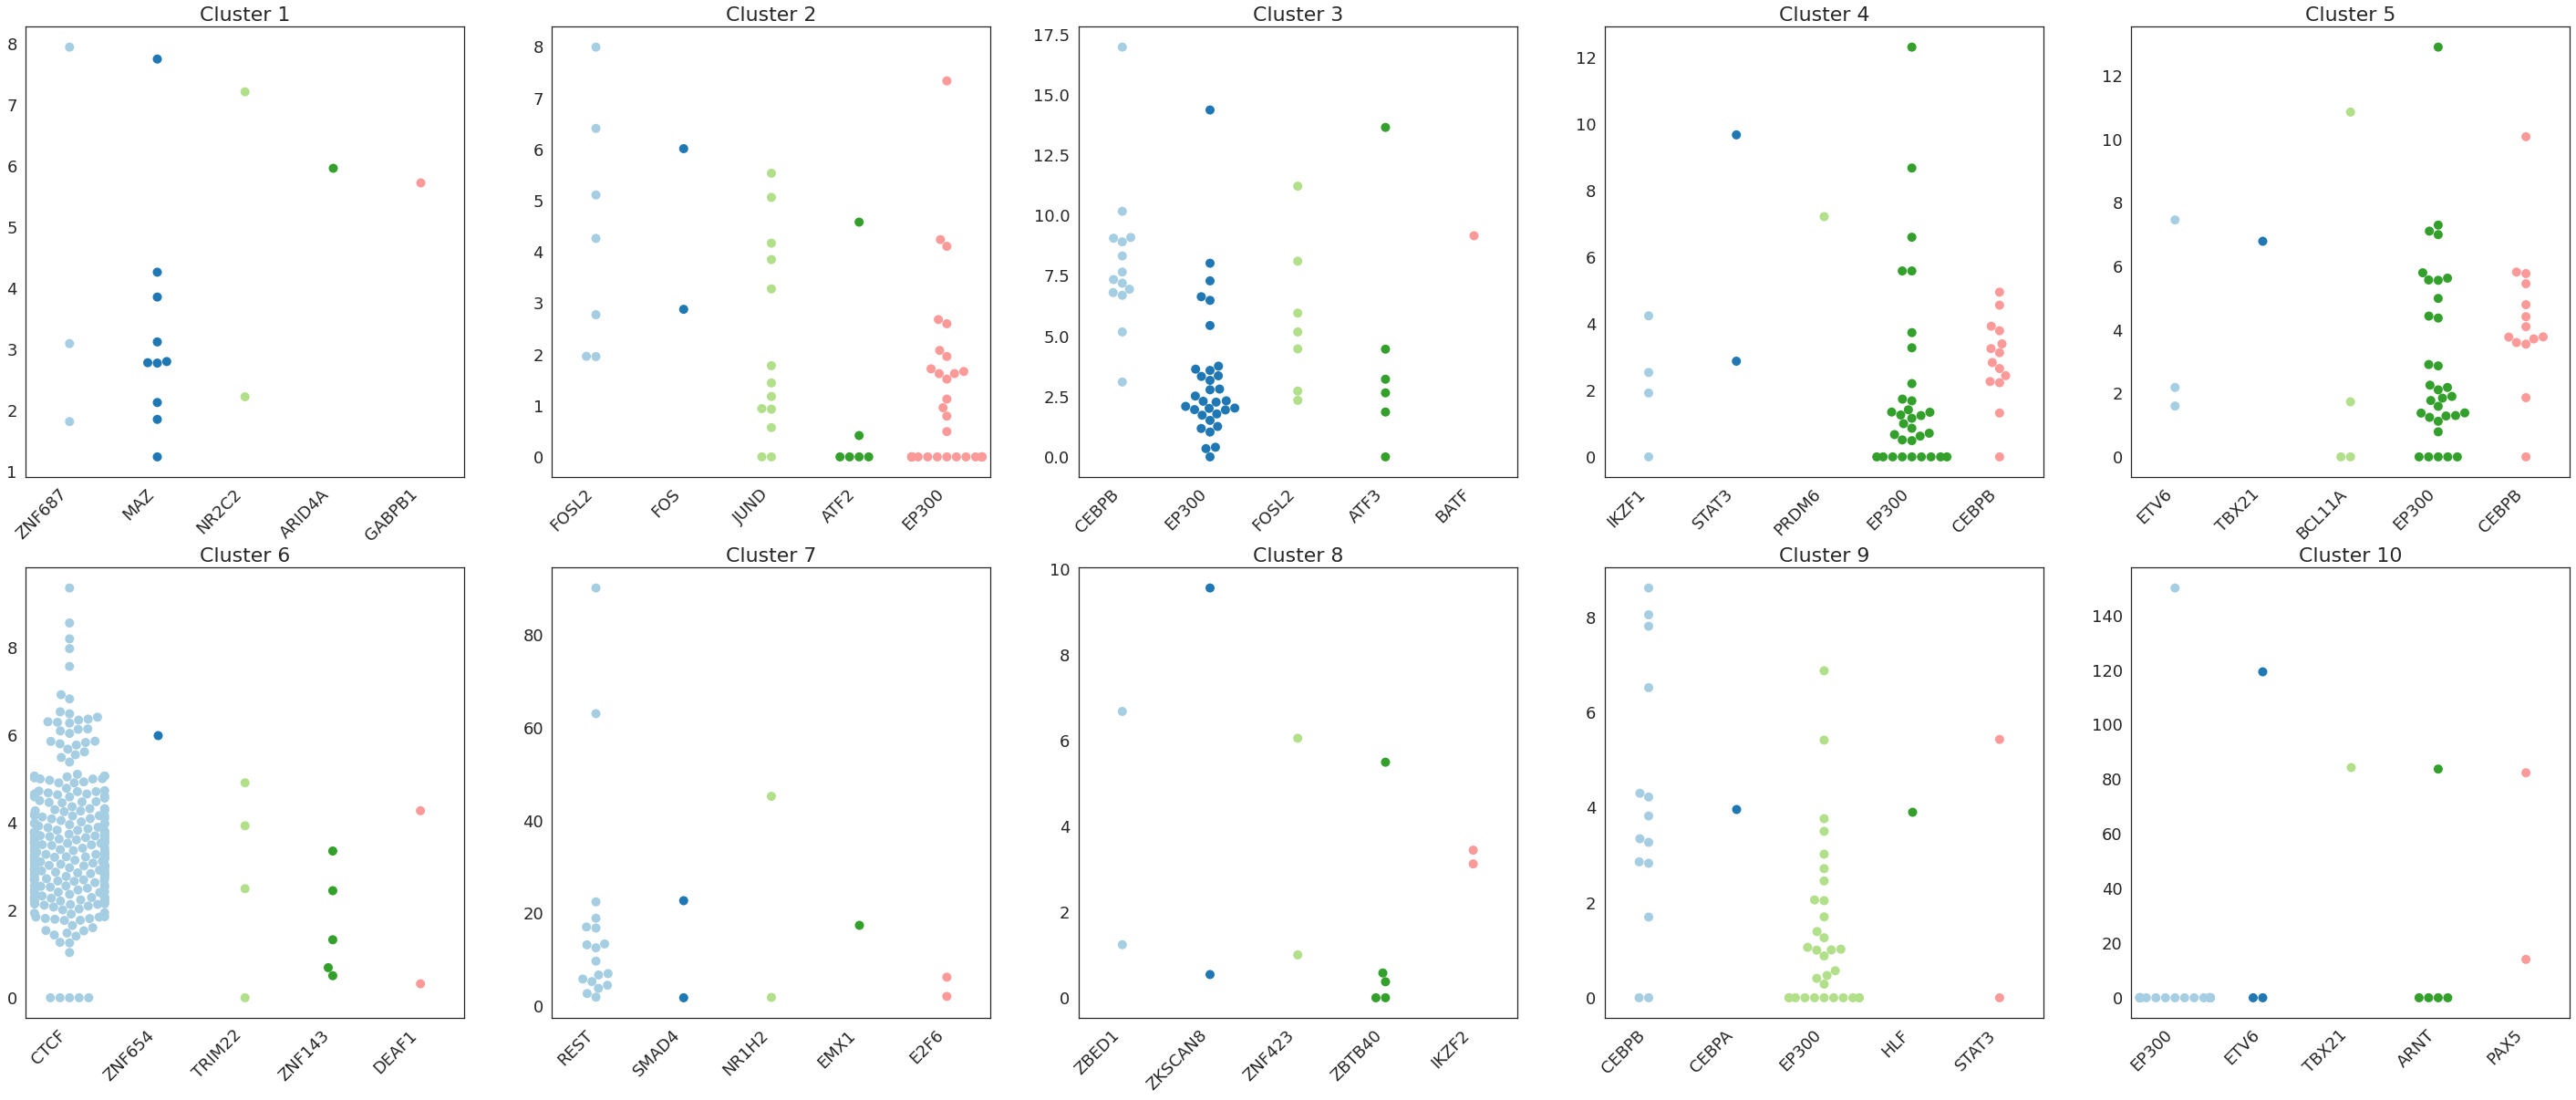

In [123]:
fig, axes = plt.subplots(2, 5, figsize=(50,20))

top_tfs = {}

for count, clust in enumerate(cluster_labels):
    row = 0 if count < 5 else 1
    col = count if count < 5 else count - 5
    clust_df = locResults.loc[locResults['userSet'] == clust + 1]
    axes[row, col].set_title(f'Cluster {clust +1}', fontsize=22)
    top_tf = plot_tf_enrichment(clust_df, axes[row,col], ranked_tf=5)
    top_tfs[count + 1] = top_tf

## Model Assessment

### Load Validation Data

In [124]:
validation_files = [get_sample_matrix_info(blood_meta[sample]) for sample in val_samples]
validation_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in validation_files}

In [125]:
val_methylation, val_header, val_rows = retrieve_sample_methylation(validation_files, n_jobs=16, 
                                                                    verbosity=10, rows=list(epm_matrix.index), quantile_norm=quant)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  30 | elapsed:   46.1s remaining:  6.9min
[Parallel(n_jobs=16)]: Done   7 out of  30 | elapsed:   48.6s remaining:  2.7min
[Parallel(n_jobs=16)]: Done  11 out of  30 | elapsed:   52.4s remaining:  1.5min
[Parallel(n_jobs=16)]: Done  15 out of  30 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=16)]: Done  19 out of  30 | elapsed:  1.4min remaining:   47.8s
[Parallel(n_jobs=16)]: Done  23 out of  30 | elapsed:  1.5min remaining:   26.7s
[Parallel(n_jobs=16)]: Done  27 out of  30 | elapsed:  1.5min remaining:   10.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:  1.6min finished


In [126]:
cleaned_val_header = [x.replace('"', '').split('_')[0] for x in val_header][1:]

In [127]:
val_matrix = pd.DataFrame(val_methylation, columns = cleaned_val_header, index=val_rows)
val_matrix = val_matrix.loc[epm_matrix.index]

In [128]:
val_modeling = ref_meta.loc[list(val_matrix)][modeling_traits]

In [129]:
val_model_values = scaler.transform(val_modeling.values)

### Validation predictions 

In [130]:
for model_label in epm_models:
    states, val_meth_predictions = epm_models[model_label]['model'].predict(val_matrix.values, return_site_predictions=True)
    expected_a_states = basic_func(val_model_values[:,0], *epm_models['epm_4']['popt'])
    v_residuals = val_meth_predictions - val_matrix.values 
    v_r2 = r2(states[:, 0], expected_a_states)
    v_mae = mae(states[:, 0], expected_a_states)
    epm_models[model_label].update(dict(v_states=states, v_residuals=v_residuals,
                                        v_expected_a_states=expected_a_states,
                                        v_mae=v_mae, v_r2=v_r2, v_meth_predictions=val_meth_predictions))

In [131]:
fpr, tpr, _ = roc_curve(val_model_values[:,1], epm_models['epm_4']['v_states'][:,1])
val_auc = auc(fpr, tpr)
epm_models['epm_4']['val_fpr'] = fpr 
epm_models['epm_4']['val_tpr'] = tpr 
epm_models['epm_4']['val_auc'] = val_auc 

In [132]:
expected_pc1_states = lin_func(val_model_values[:, 2], *epm_models['epm_4']['pc1_popt'])
epm_models['epm_4']['val_pc1_expected'] = expected_pc1_states
epm_models['epm_4']['val_pc1_r2'] = r2(val_model_values[:,2], expected_pc1_states)
epm_models['epm_4']['val_pc1_mae'] = mae(val_model_values[:,2], expected_pc1_states)

In [133]:
expected_pc2_states = lin_func(val_model_values[:, 3], *epm_models['epm_4']['pc2_popt'])
epm_models['epm_4']['val_pc2_expected'] = expected_pc2_states
epm_models['epm_4']['val_pc2_r2'] = r2(val_model_values[:,3], expected_pc2_states)
epm_models['epm_4']['val_pc2_mae'] = mae(val_model_values[:,3], expected_pc2_states)

### Test Predictions

In [134]:
test_meta = {sample: info for sample, info in sample_meta.items() if sample_check(info, relative_intensity_filter=blood_450k_fit) if info['experiment_id'] in test_exps}

In [135]:
test_files = [get_sample_matrix_info(info) for info in test_meta.values()]
test_files = {sample[0]: f'{processing_dir}{sample[1]}_methmatrix.gz' for sample in test_files}

In [136]:
test_methylation, test_header, test_rows = retrieve_sample_methylation(test_files, n_jobs=16, 
                                                                    verbosity=10, rows=list(epm_matrix.index),
                                                                    quantile_norm=quant)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  2.6min
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:  4.7min
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  5.7min
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:  7.5min
[Parallel(n_jobs=16)]: Done  71 out of  92 | elapsed:  9.8min remaining:  2.9min
[Parallel(n_jobs=16)]: Done  81 out of  92 | elapsed: 10.5min remaining:  1.4min
[Parallel(n_jobs=16)]: Done  92 out of  92 | elapsed: 11.4min finished


In [137]:
cleaned_test_header = [x.replace('"', '').split('_')[0] for x in test_header][1:]

In [138]:
test_matrix = pd.DataFrame(test_methylation, columns=cleaned_test_header, index=test_rows)

In [139]:
test_matrix = test_matrix[list(test_matrix)].loc[epm_matrix.index]

In [140]:
test_meta_df = ref_meta.loc[list(test_matrix)][modeling_traits]

In [141]:
test_modeling = test_meta_df[modeling_traits]

In [142]:
test_modeling_values = scaler.transform(test_modeling.values)

In [143]:
for model_label in epm_models:
    states, t_meth_predictions = epm_models[model_label]['model'].predict(test_matrix.values, return_site_predictions=True)
    t_residuals = t_meth_predictions - test_matrix.values
    expected_a_states = basic_func(abs(test_modeling_values[:,0]), *epm_models['epm_4']['popt'])
    t_r2 = r2(states[:, 0], expected_a_states)
    t_mae = mae(states[:, 0], expected_a_states)
    epm_models[model_label].update(dict(t_states=states, t_residuals=t_residuals,
                                        t_expected_a_states=expected_a_states,
                                        t_mae=t_mae, t_r2=v_r2, t_meth_predictions=t_meth_predictions))

In [144]:
fpr, tpr, _ = roc_curve(test_modeling_values[:,1], epm_models['epm_4']['t_states'][:,1])
test_auc = auc(fpr, tpr)
epm_models['epm_4']['test_fpr'] = fpr 
epm_models['epm_4']['test_tpr'] = tpr 
epm_models['epm_4']['test_auc'] = test_auc 

In [145]:
expected_pc1_states = lin_func(test_modeling_values[:, 2], *epm_models['epm_4']['pc1_popt'])
epm_models['epm_4']['test_pc1_expected'] = expected_pc1_states
for count, model in enumerate(list(epm_models.keys())):
    if count < 2:
        continue
    epm_models[model]['test_pc1_r2'] = r2(epm_models[model]['t_states'][:,2], expected_pc1_states)
    epm_models[model]['test_pc1_mae'] = mae(epm_models[model]['t_states'][:, 2], expected_pc1_states)

In [146]:
expected_pc2_states = lin_func(test_modeling_values[:, 3], *epm_models['epm_4']['pc2_popt'])
epm_models['epm_4']['test_pc2_expected'] = expected_pc2_states
for count, model in enumerate(list(epm_models.keys())):
    if count < 3:
        continue
    epm_models[model]['test_pc2_r2'] = r2(epm_models[model]['t_states'][:,3], expected_pc2_states)
    epm_models[model]['test_pc2_mae'] = mae(epm_models[model]['t_states'][:, 3], expected_pc2_states)

In [147]:
traits_modeled_labels = ['Age', 'Age, Sex', 'Age, Sex, CT-PC1', 'Age, Sex, CT-PC1, CT-PC2']

In [148]:
model_states = []

for count, model in enumerate(epm_models.values()):
    # get states
    train_states = model['states']
    val_states = model['v_states']
    test_states = model['t_states']
    
    # get pheno values 
    train_vals = np.copy(train_pheno_values[:,:count+1])
    val_vals = np.copy(val_model_values[:,:count+1])
    test_vals = np.copy(test_modeling_values[:,:count+1])
    
    # susitute expected age vs fit trend 
    train_vals[:,0] = model['expected_a_states']
    val_vals[:,0] = model['v_expected_a_states']
    test_vals[:,0] = model['t_expected_a_states']
    
    # calculate error 
    abs_train = abs(train_states - train_vals[:,:count+1])
    abs_val = abs(val_states - val_vals[:,:count+1])
    abs_test = abs(test_states - test_vals[:,:count+1])
    
    for x in range(count+1):
        for y in abs_train[:, x]:
            model_states.append([list(train_modeling)[x], y, 'Train', traits_modeled_labels[count]])
        for y in abs_val[:, x]:
            model_states.append([list(train_modeling)[x], y, 'Validation', traits_modeled_labels[count]])
        for y in abs_test[:, x]:
            model_states.append([list(train_modeling)[x], y, 'Test', traits_modeled_labels[count]])
            
states_error_df = pd.DataFrame(model_states, columns=['Trait', 'Error', 'Split', 'Traits Modeled'])

In [149]:
mean_meth = []

for count, model in enumerate(epm_models.values()):
    plt_x = math.floor(count /3)
    plt_y = count - plt_x * 3
    mean_meth.extend([{'Methylation Site MAE':x, 'Traits Modeled':traits_modeled_labels[count], 'Site Type': label, 'Model':'Train'} 
                      for x, label in zip(np.mean(abs(model['residuals']), axis=1), site_cats)])
    mean_meth.extend([{'Methylation Site MAE':x, 'Traits Modeled':traits_modeled_labels[count], 'Site Type': label, 'Model':'Validation'} 
                      for x, label in zip(np.mean(abs(model['v_residuals']), axis=1), site_cats)])
    mean_meth.extend([{'Methylation Site MAE':x, 'Traits Modeled':traits_modeled_labels[count], 'Site Type': label, 'Model':'Test'} 
                      for x, label in zip(np.mean(abs(model['t_residuals']), axis=1), site_cats)])
  

epm_res = pd.DataFrame(mean_meth)

### Plot Model Predictions

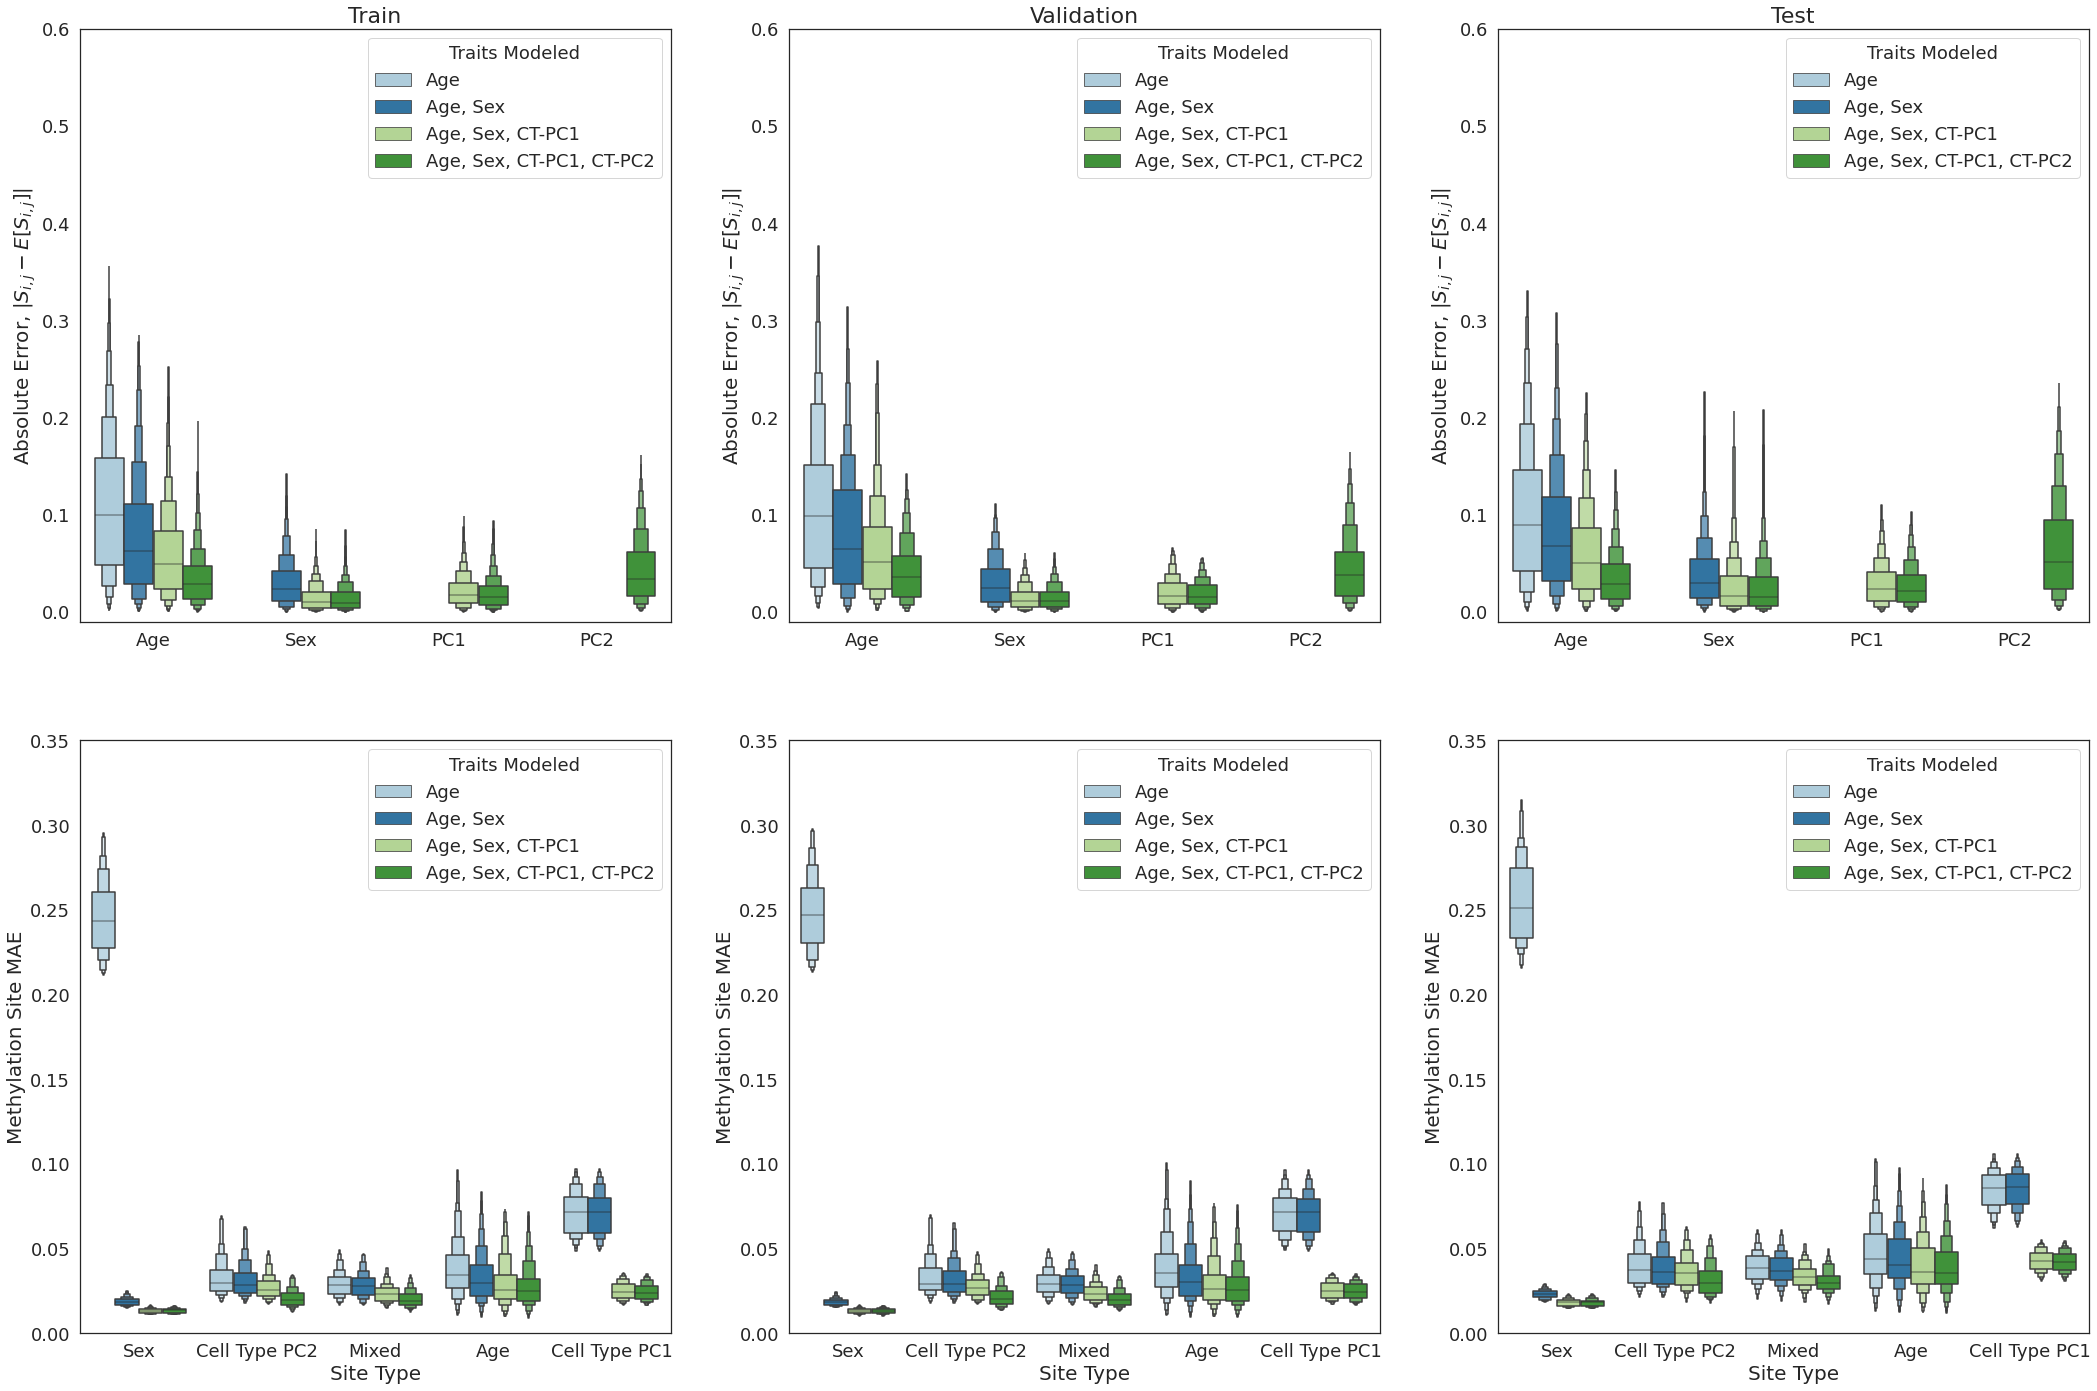

In [150]:
fig, ax = plt.subplots(2, 3, figsize=(36,24))

models = ['Train', 'Validation', 'Test']

for count in range(3):
    ax[0, count].set_title(models[count], fontsize=22)
    sns.boxenplot(y='Error', x='Trait', hue='Traits Modeled', 
                data=states_error_df.loc[states_error_df['Split'] == models[count]], 
                ax=ax[0, count], showfliers=False, k_depth='proportion', outlier_prop=.025)
    ax[0, count].set_ylim([-0.01, .6])
    ax[0, count].set_ylabel('Absolute Error, $|S_{i,j} - E[S_{i,j}]|$')
    ax[0, count].set_xlabel('')
    
    
for count, model in enumerate(['Train', 'Validation', 'Test']):
    plot_df = epm_res.loc[epm_res['Model'] == model]
    ax[1, count].set_ylim([0.00, .35])
    sns.boxenplot(x='Site Type', y='Methylation Site MAE', hue='Traits Modeled', data=plot_df, ax=ax[1, count],
                  k_depth='proportion', outlier_prop=.05, showfliers=False)
    
plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure6.png'), bbox_inches='tight', dpi=200)

plt.show()

In [151]:
def plot_assoc(x, y, ax, m_r2=None, mae=None, popt=None, x_min=0, x_max=1, 
               xlabel=None, ylabel=None, plot_func=basic_func, association='^{{0.5}}'):
    sns.scatterplot(x=x, y=y, ax=ax, c=np.array([sns.color_palette("Set2")[2]]))
    x_range = np.linspace(x_min, x_max, 500)
    if any(popt):
        sign = '+' if popt[2] > 0 else '' 
        fit_label = f'$f(x) = {popt[0]: .3f}x{association} {sign} {popt[2]: .3f}$\n$R^2={m_r2: .3f}$, $MAE={mae: .3f}$'
        expected_range = plot_func(x_range, *popt)
        ax.plot(x_range, expected_range, 'k--', lw=2, label=fit_label)
    ax.legend(fontsize=20, loc='upper left', 
              frameon=True)
    ax.set_xlabel(f'{xlabel}', fontsize=22)
    ax.set_ylabel(f'{ylabel}', fontsize=22)
    return ax

In [152]:
def plot_meth_2d_hist(actual, predicted, ax, fig):
    mmr2 = stats.pearsonr(actual, predicted)[0]**2
    mmae = np.mean(abs(actual - predicted))
    h = ax.hist2d(x=actual, y=predicted, 
                 bins=100, cmap=plt.cm.BuPu, norm=LogNorm(vmin=1, vmax=50000))
    ax.plot([0,1], [0,1], 'k--')
    ax.set_ylim([-.25, 1.5])
    ax.set_xlim([0,1])
    ax.set_ylabel('Predicted Methylation Value')
    ax.set_xlabel('Observed Methylation Value')
    ax.text(.01,.95,f'$R^2={mmr2:.3f}$, $MAE={mmae:.3f}$', fontsize=20, transform=ax.transAxes)
    cbar = fig.colorbar(h[3], ax=ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(f'Density', rotation=270)

In [153]:
epm_models['epm_1']['t_states'].shape

(4082, 1)

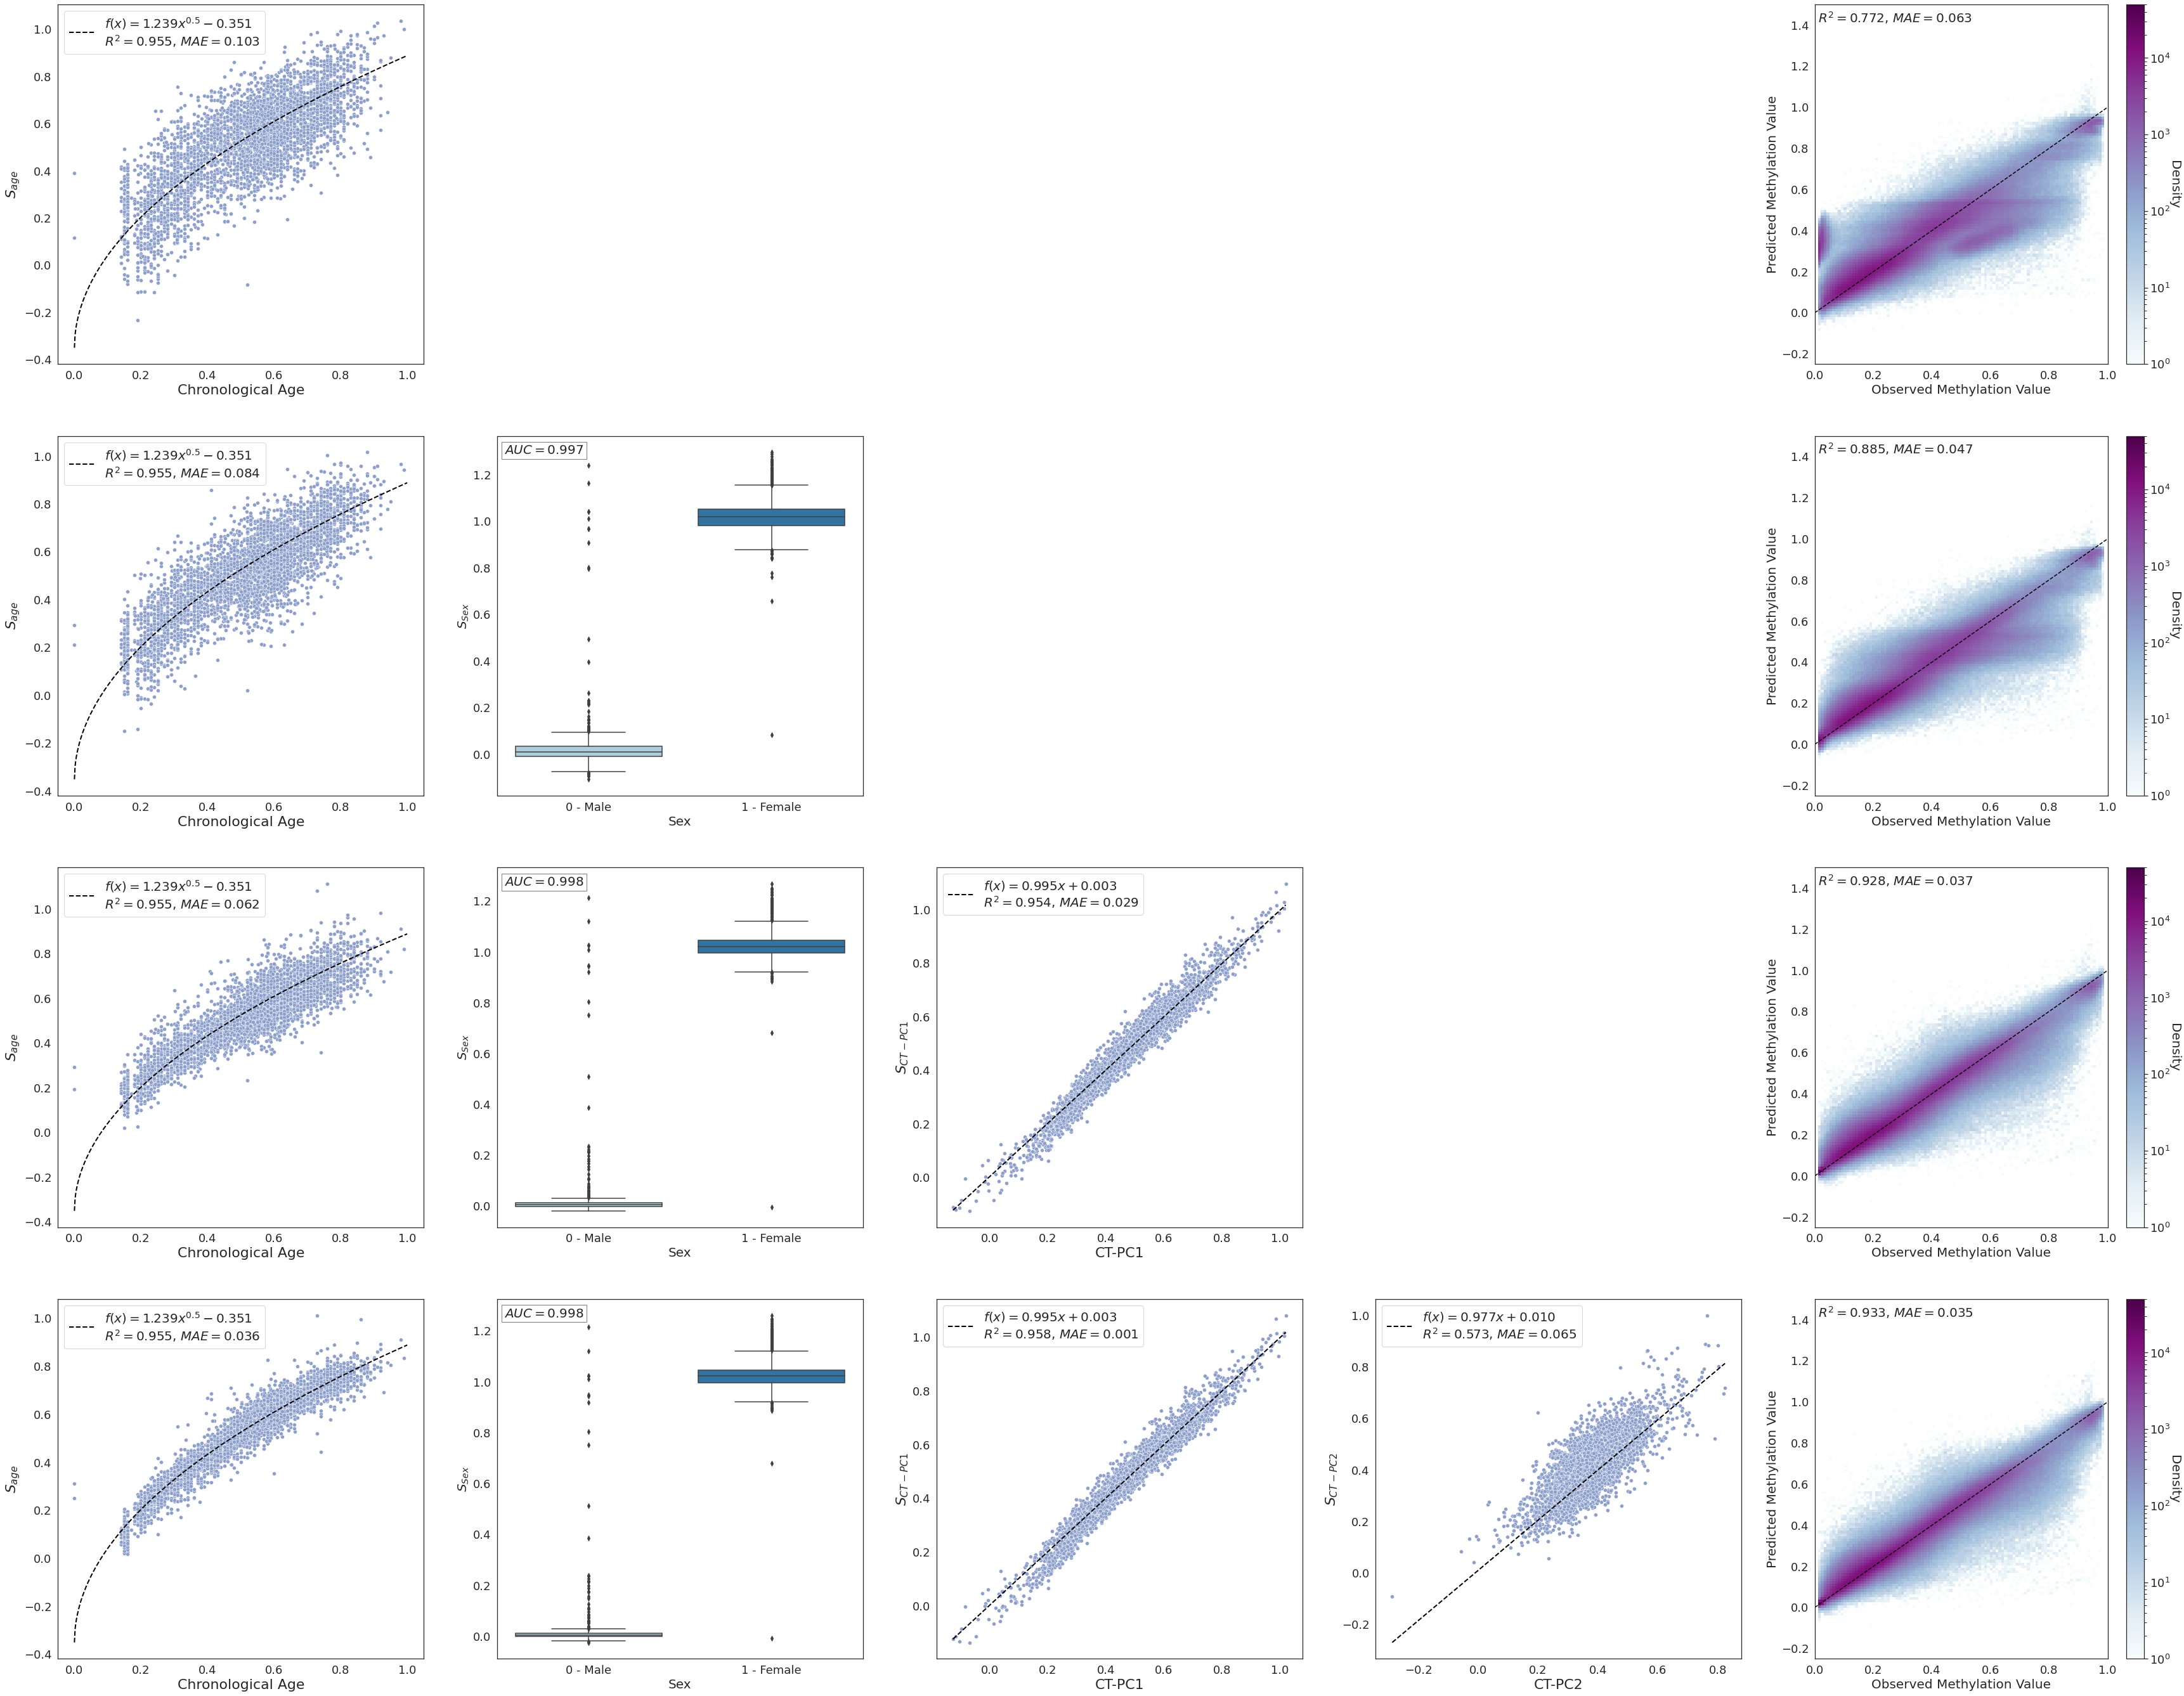

In [154]:
fig, ax = plt.subplots(4, 5, figsize=(12*5, 12*4))

for m_count, model in enumerate(list(epm_models.values())):
    for count in range(model['t_states'].shape[1]):
        if count == 1:
            fpr, tpr, _ = roc_curve(test_modeling_values[:,1], model['t_states'][:,1])
            test_auc = auc(fpr, tpr)
            sns.boxplot(y=model['t_states'][:, count], 
                        x=test_modeling_values[:, count], ax=ax[m_count, count])
            plt.setp(ax[0, count].artists, edgecolor = 'k', facecolor='w')
            plt.setp(ax[0, count].lines, color='k')
            ax[m_count, count].text(0.02, .95, f'$AUC={test_auc:.3f}$', 
                              fontsize=20, transform=ax[m_count,count].transAxes,
                              bbox=dict(facecolor='none', edgecolor='grey'))
            ax[m_count, count].set_xlabel(f'Sex')
            ax[m_count, count].set_ylabel(f'$S_{{Sex}}$')
            ax[m_count, count].set_xticklabels(['0 - Male', '1 - Female'])

        elif count == 0:
            plot_assoc(test_modeling_values[:,0], model['t_states'][:, 0], ax[m_count, count],
                    m_r2=model['t_r2'], mae=model['t_mae'], 
                     popt=epm_models['epm_4']['popt'], 
                     xlabel='Chronological Age', ylabel='$S_{age}$')
        else:
            pc_count = 1 if count == 2 else 2
            epm_models['epm_4']['test_pc1_mae'] = mae(test_modeling_values[:,2], expected_pc1_states)
            plot_assoc(test_modeling_values[:,count], model['t_states'][:, count], ax[m_count, count],
                       m_r2=model[f'test_pc{pc_count}_r2'], mae=model[f'test_pc{pc_count}_mae'], 
                       popt=epm_models['epm_4'][f'pc{pc_count}_popt'], plot_func=lin_func, 
                       x_min=min(test_modeling_values[:,count]), x_max=max(test_modeling_values[:,count]),
                       xlabel=f'CT-PC{pc_count}', ylabel=f'$S_{{CT-PC{pc_count}}}$', association='')
    plot_meth_2d_hist(test_matrix.values.flatten(), model['t_meth_predictions'].flatten(), ax[m_count, 4], fig)
    
for count in range(3):
    for empty_plot in range(3-count):
        ax[count, 3 - empty_plot].axis('off')
        
plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure2.png'), dpi=200, bbox_inches='tight')

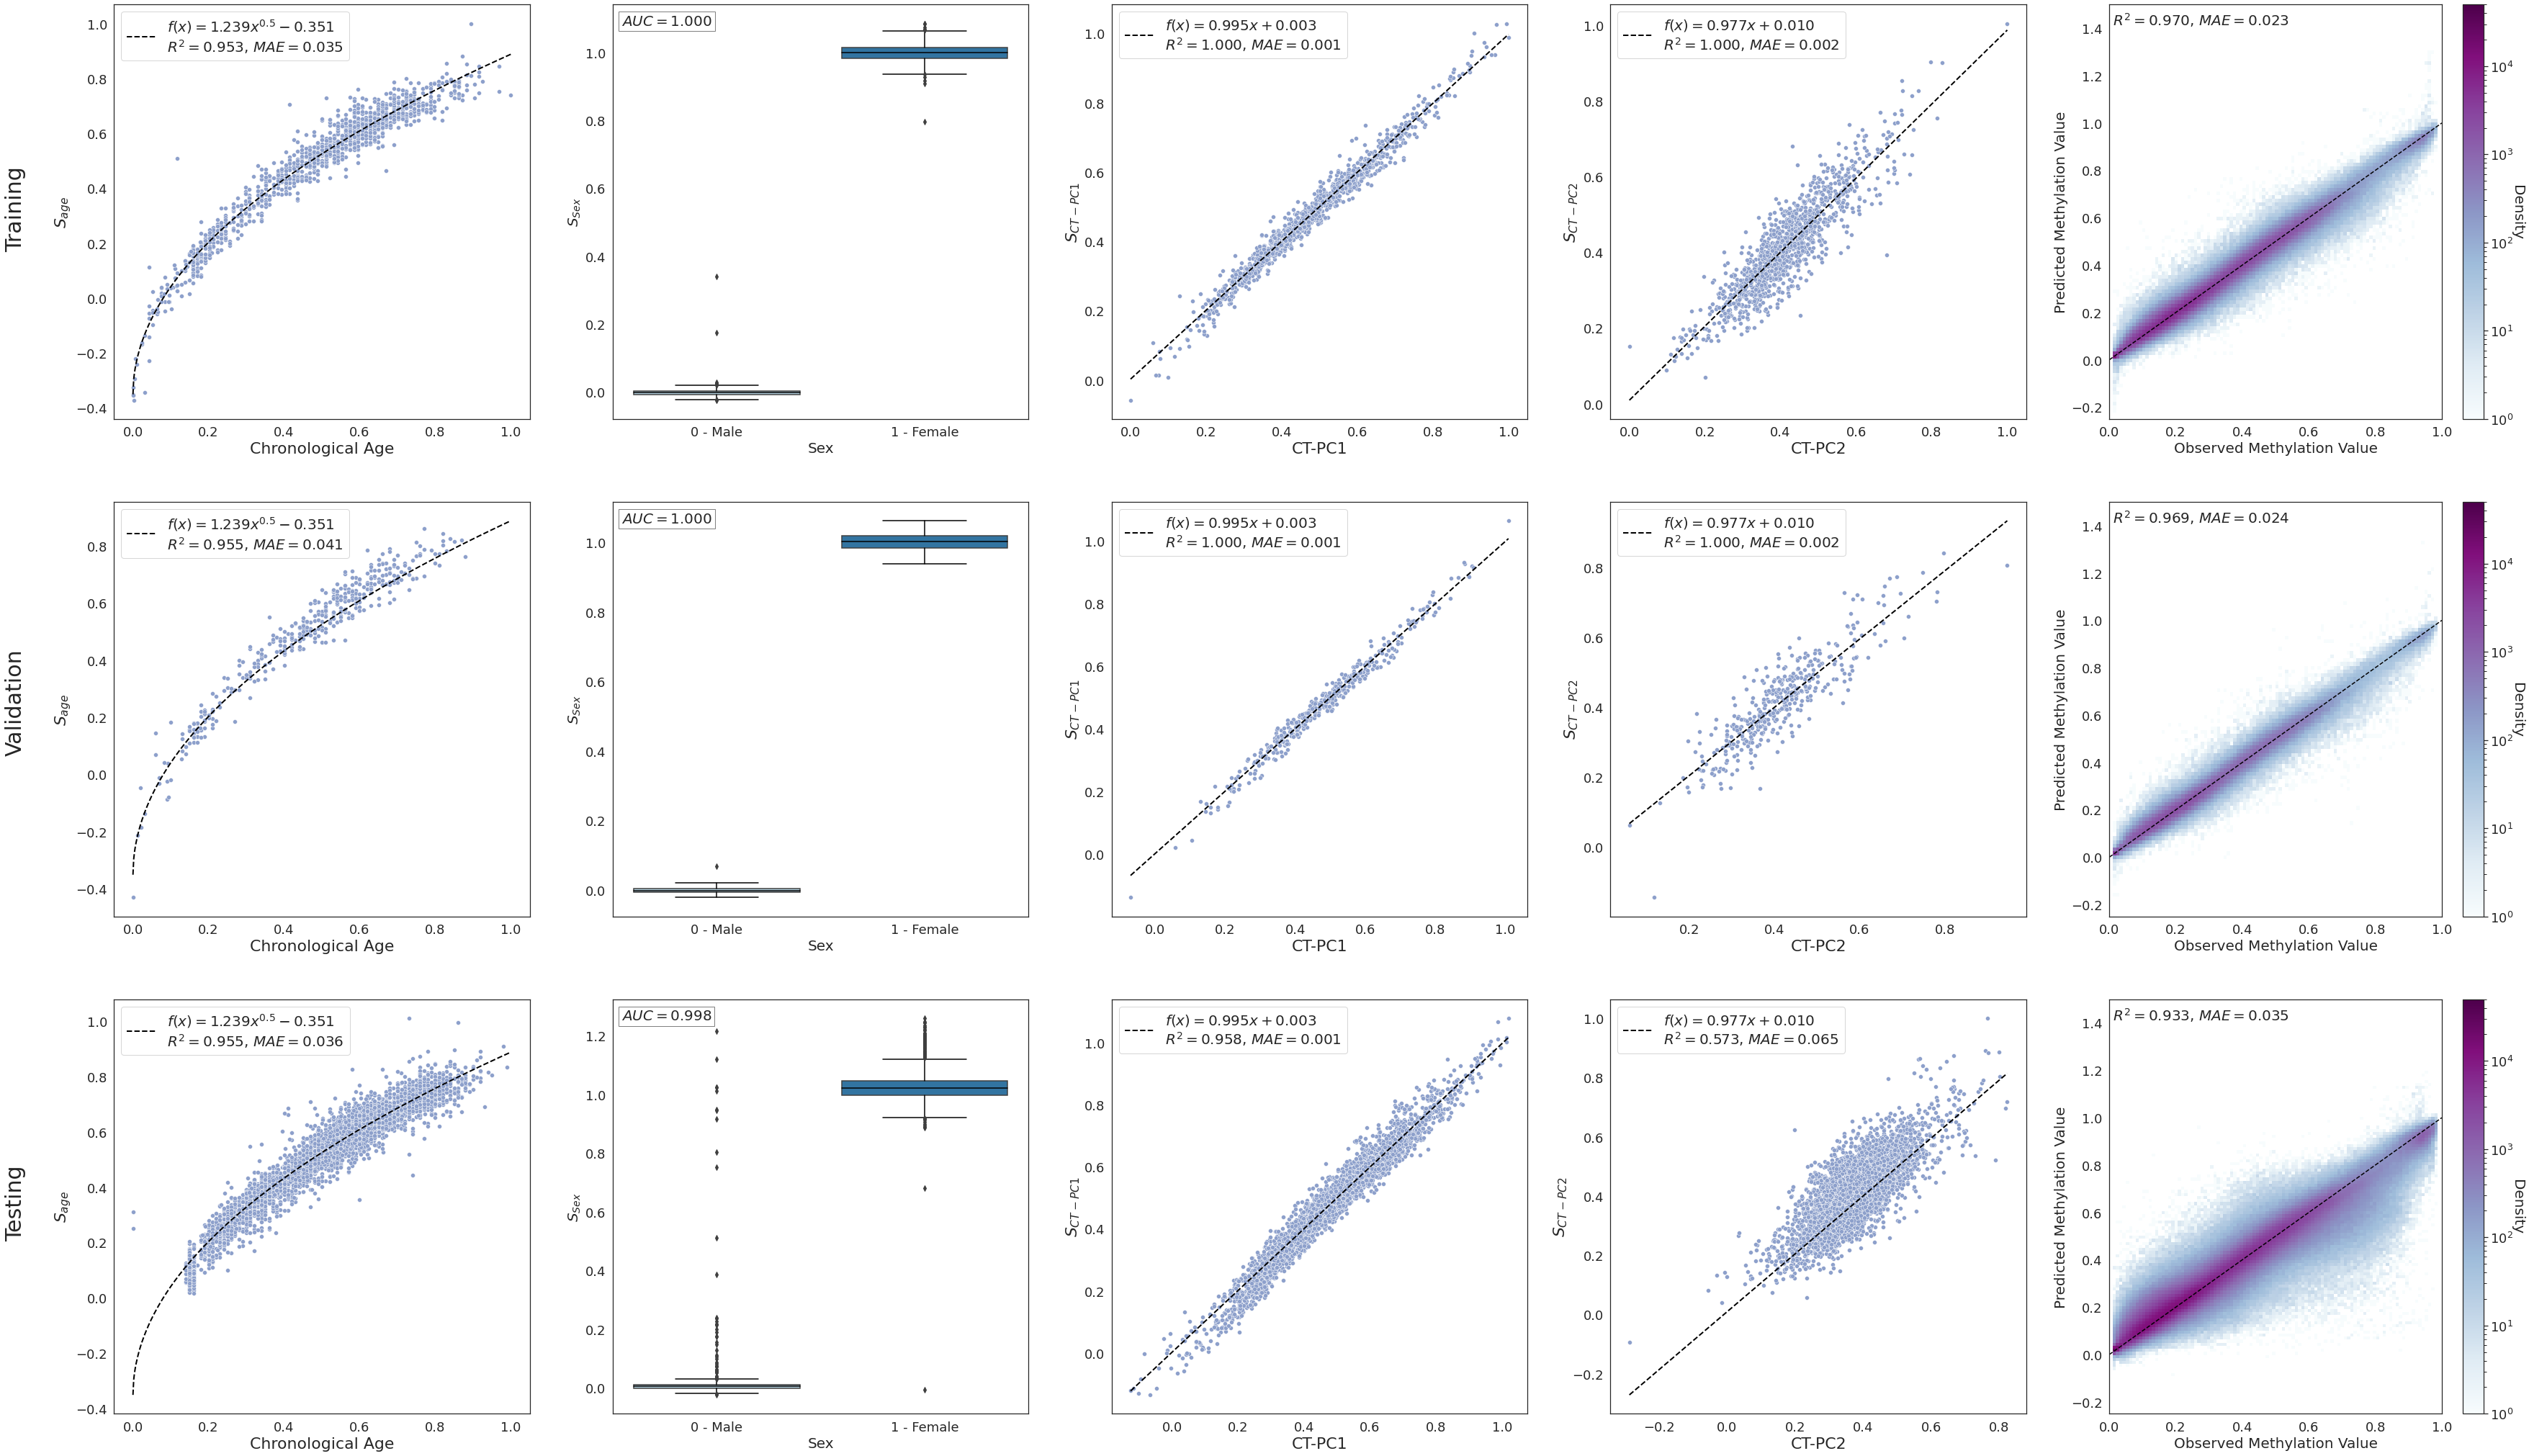

In [155]:
fig, ax = plt.subplots(3, 5, figsize=(12*5, 12*3))

for count, trait in enumerate(list(val_modeling)):
    if count == 1:
        sns.boxplot(y=epm_models['epm_4']['states'][:, count], 
                    x=train_pheno_values[:, count], ax=ax[0, count])
        plt.setp(ax[0, count].artists, edgecolor = 'k', facecolor='w')
        plt.setp(ax[0, count].lines, color='k')
        ax[0, count].text(0.02, .95, f'$AUC={epm_models["epm_4"]["train_auc"]:.3f}$', 
                          fontsize=20, transform=ax[0,count].transAxes,
                          bbox=dict(facecolor='none', edgecolor='grey'))
        ax[0, count].set_xlabel(f'{trait}')
        ax[0, count].set_ylabel(f'$S_{{{trait}}}$')
        
        sns.boxplot(y=epm_models['epm_4']['v_states'][:, count], 
                    x=val_model_values[:, count], ax=ax[1, count])
        ax[1, count].set_xlabel(f'{trait}')
        ax[1, count].set_ylabel(f'$S_{{{trait}}}$')
        plt.setp(ax[1, count].artists, edgecolor = 'k', facecolor='w')
        plt.setp(ax[1, count].lines, color='k')
        ax[1, count].text(0.02, .95, f'$AUC={epm_models["epm_4"]["val_auc"]:.3f}$', 
                          fontsize=20, transform=ax[1,count].transAxes,
                          bbox=dict(facecolor='none', edgecolor='grey'))
        
        sns.boxplot(y=epm_models['epm_4']['t_states'][:, count], 
                    x=test_modeling_values[:, count], ax=ax[2, count])
        ax[2, count].set_xlabel(f'{trait}')
        ax[2, count].set_ylabel(f'$S_{{{trait}}}$')
        plt.setp(ax[2, count].artists, edgecolor = 'k', facecolor='w')
        plt.setp(ax[2, count].lines, color='k')
        ax[2, count].text(0.02, .95, f'$AUC={epm_models["epm_4"]["test_auc"]:.3f}$', 
                          fontsize=20, transform=ax[2,count].transAxes,
                          bbox=dict(facecolor='none', edgecolor='grey'))
        ax[0, count].set_xticklabels(['0 - Male', '1 - Female'])
        ax[1, count].set_xticklabels(['0 - Male', '1 - Female'])
        ax[2, count].set_xticklabels(['0 - Male', '1 - Female'])
        
    elif count == 0:
        plot_assoc(train_pheno_values[:,0], epm_models['epm_4']['states'][:, 0], ax[0, count],
                 m_r2=epm_models['epm_4']['m_r2'], mae=epm_models['epm_4']['m_mae'], 
                 popt=epm_models['epm_4']['popt'], 
                 xlabel='Chronological Age', ylabel='$S_{age}$')
        
        plot_assoc(val_model_values[:,0], epm_models['epm_4']['v_states'][:, 0], ax[1, count],
                   m_r2=epm_models['epm_4']['v_r2'], mae=epm_models['epm_4']['v_mae'], 
                   popt=epm_models['epm_4']['popt'], 
                   xlabel='Chronological Age', ylabel='$S_{age}$')
        
        plot_assoc(test_modeling_values[:,0], epm_models['epm_4']['t_states'][:, 0], ax[2, count],
                m_r2=epm_models['epm_4']['t_r2'], mae=epm_models['epm_4']['t_mae'], 
                 popt=epm_models['epm_4']['popt'], 
                 xlabel='Chronological Age', ylabel='$S_{age}$')
    else:
        pc_count = 1 if count == 2 else 2
        plot_assoc(train_pheno_values[:,count], epm_models['epm_4']['states'][:, count], ax[0, count],
                   m_r2=epm_models['epm_4'][f'train_pc{pc_count}_r2'], mae=epm_models['epm_4'][f'train_pc{pc_count}_mae'], 
                   popt=epm_models['epm_4'][f'pc{pc_count}_popt'], association='', plot_func=lin_func,
                   x_min=min(train_pheno_values[:,count]), x_max=max(train_pheno_values[:,count]),
                   xlabel=f'CT-{trait}', ylabel=f'$S_{{CT-{trait}}}$')
        
        plot_assoc(val_model_values[:,count], epm_models['epm_4']['v_states'][:, count], ax[1, count],
                   m_r2=epm_models['epm_4'][f'val_pc{pc_count}_r2'], mae=epm_models['epm_4'][f'val_pc{pc_count}_mae'], 
                   popt=epm_models['epm_4'][f'pc{pc_count}_popt'], association='', plot_func=lin_func,
                   x_min=min(val_model_values[:,count]), x_max=max(val_model_values[:,count]),
                   xlabel=f'CT-{trait}', ylabel=f'$S_{{CT-{trait}}}$')
        
        plot_assoc(test_modeling_values[:,count], epm_models['epm_4']['t_states'][:, count], ax[2, count],
                   m_r2=epm_models['epm_4'][f'test_pc{pc_count}_r2'], mae=epm_models['epm_4'][f'test_pc{pc_count}_mae'], 
                   popt=epm_models['epm_4'][f'pc{pc_count}_popt'], plot_func=lin_func, 
                   x_min=min(test_modeling_values[:,count]), x_max=max(test_modeling_values[:,count]),
                   xlabel=f'CT-{trait}', ylabel=f'$S_{{CT-{trait}}}$', association='')

plot_meth_2d_hist(epm_matrix.values.flatten(), epm_models['epm_4']['train_predicted_meth'].flatten(), ax[0, 4], fig)
plot_meth_2d_hist(val_matrix.values.flatten(), epm_models['epm_4']['v_meth_predictions'].flatten(), ax[1, 4], fig)
plot_meth_2d_hist(test_matrix.values.flatten(), epm_models['epm_4']['t_meth_predictions'].flatten(), ax[2, 4], fig)
        
ax[0,0].text(.09, .75, 'Training', fontsize=30, rotation=90, transform=plt.gcf().transFigure)
ax[0,0].text(.09, .48, 'Validation', fontsize=30, rotation=90, transform=plt.gcf().transFigure)
ax[0,0].text(.09, .22, 'Testing', fontsize=30, rotation=90, transform=plt.gcf().transFigure)


plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure7.png'), dpi=200, bbox_inches='tight')
plt.show()

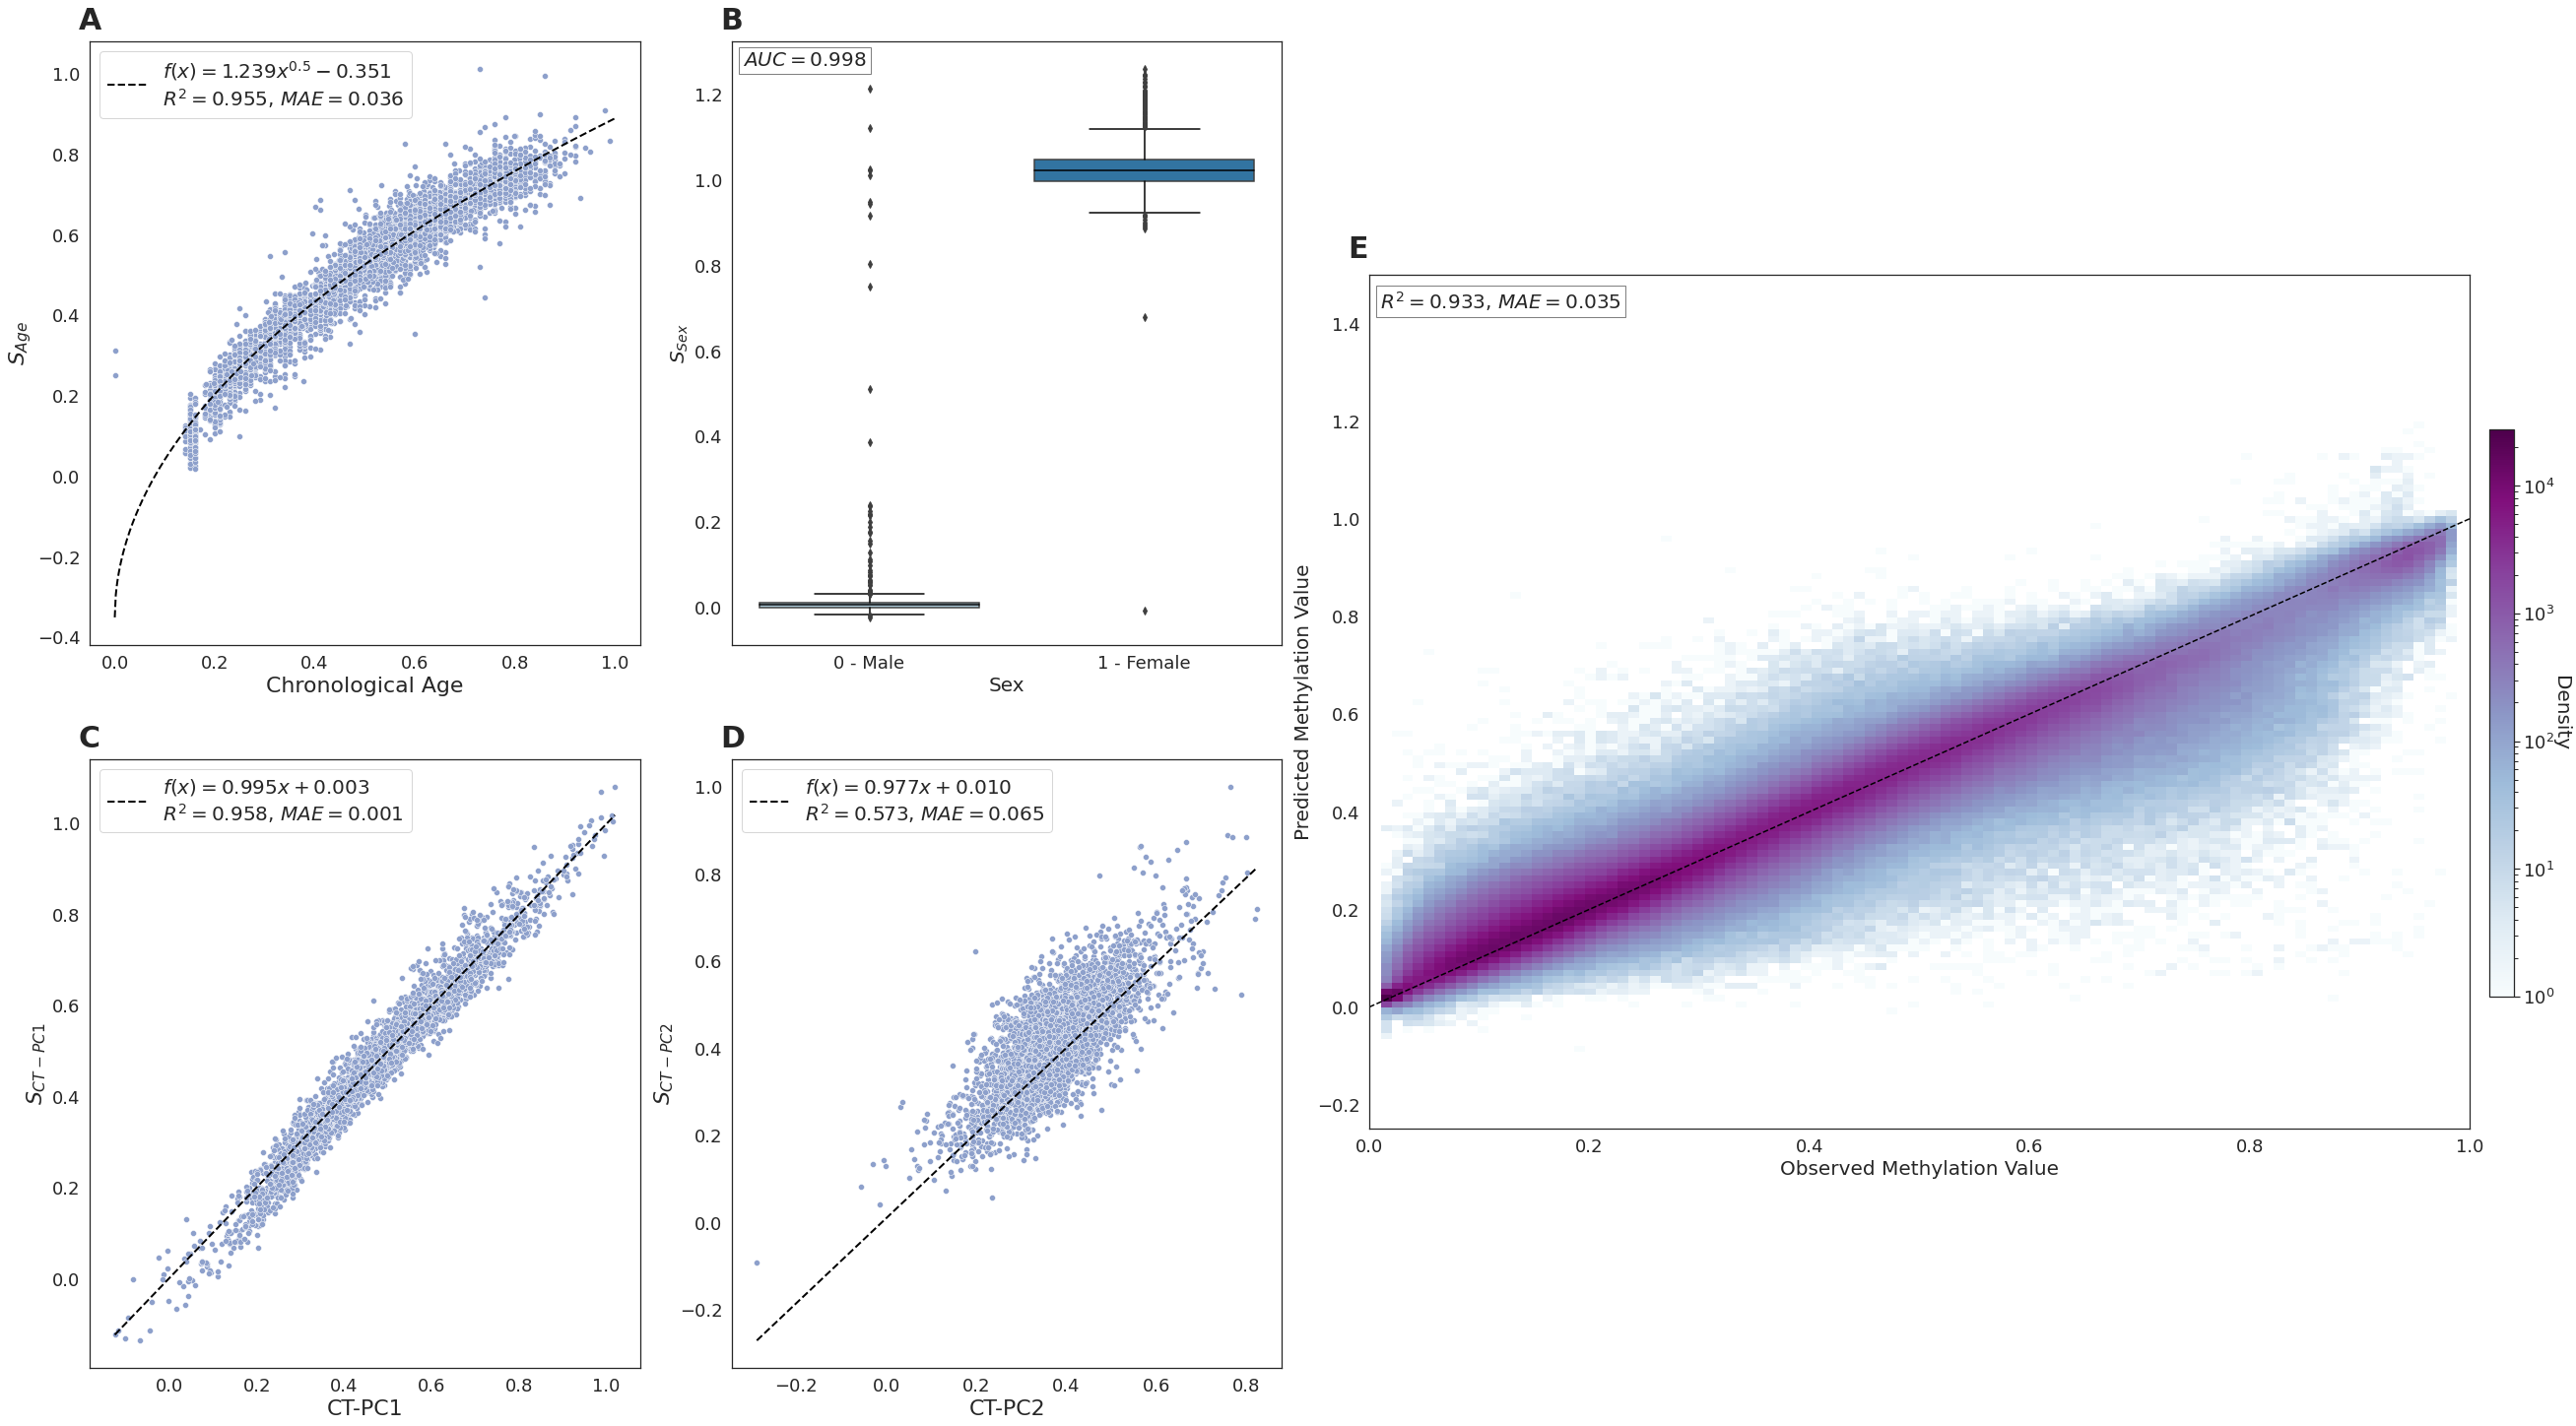

In [156]:
fig = plt.figure(constrained_layout=True, figsize=(35, 20))

gs = plt.GridSpec(6, 4, figure=fig)


ax = fig.add_subplot(gs[0:3, 0])
ax.text(-0.02, 1.02, 'A', fontsize=30, weight='bold', transform=ax.transAxes)

plot_assoc(test_modeling_values[:,0], epm_models['epm_4']['t_states'][:, 0], ax,
                m_r2=epm_models['epm_4']['t_r2'], mae=epm_models['epm_4']['t_mae'], 
                 popt=epm_models['epm_4']['popt'], 
                 xlabel='Chronological Age', ylabel='$S_{Age}$')

ax = fig.add_subplot(gs[0:3, 1])
ax.text(-0.02, 1.02, 'B', fontsize=30, weight='bold', transform=ax.transAxes)
sns.boxplot(y=epm_models['epm_4']['t_states'][:, 1], 
                    x=test_modeling_values[:, 1], ax=ax)
ax.set_xlabel(f'Sex')
ax.set_ylabel(f'$S_{{Sex}}$')
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
ax.text(0.02, .96, f'$AUC={epm_models["epm_4"]["test_auc"]:.3f}$', 
                  fontsize=20, transform=ax.transAxes,
                  bbox=dict(facecolor='none', edgecolor='grey'))
ax.set_xticklabels(['0 - Male', '1 - Female'])


ax = fig.add_subplot(gs[3:, 0])
ax.text(-0.02, 1.02, 'C', fontsize=30, weight='bold', transform=ax.transAxes)

plot_assoc(test_modeling_values[:,2], epm_models['epm_4']['t_states'][:, 2], ax,
                   m_r2=epm_models['epm_4'][f'test_pc1_r2'], mae=epm_models['epm_4'][f'test_pc1_mae'], 
                   popt=epm_models['epm_4'][f'pc1_popt'], plot_func=lin_func, 
                   x_min=min(test_modeling_values[:,2]), x_max=max(test_modeling_values[:,2]),
                   xlabel=f'CT-PC1', ylabel=f'$S_{{CT-PC1}}$',  association='')

ax = fig.add_subplot(gs[3:, 1])
ax.text(-0.02, 1.02, 'D', fontsize=30, weight='bold', transform=ax.transAxes)

plot_assoc(test_modeling_values[:,3], epm_models['epm_4']['t_states'][:, 3], ax,
                   m_r2=epm_models['epm_4'][f'test_pc2_r2'], mae=epm_models['epm_4'][f'test_pc2_mae'], 
                   popt=epm_models['epm_4'][f'pc{pc_count}_popt'], plot_func=lin_func, 
                   x_min=min(test_modeling_values[:,3]), x_max=max(test_modeling_values[:,3]),
                   xlabel=f'CT-PC2', ylabel=f'$S_{{CT-PC2}}$', association='')

    
ax = fig.add_subplot(gs[1:5, 2:])
ax.text(-0.02, 1.02, 'E', fontsize=30, weight='bold', transform=ax.transAxes)

mr2 = stats.pearsonr(test_matrix.values.flatten(), epm_models['epm_4']['t_meth_predictions'].flatten())[0]**2
mmae = np.mean(abs(test_matrix.values.flatten() - epm_models['epm_4']['t_meth_predictions'].flatten()))
h = ax.hist2d(x=test_matrix.values.flatten(), y=epm_models['epm_4']['t_meth_predictions'].flatten(), 
                    bins=100, cmap=plt.cm.BuPu, norm=LogNorm(vmin=1))
ax.plot([0,1], [0,1], 'k--')
ax.set_ylim([-.25, 1.5])
ax.set_xlim([0,1])
ax.set_ylabel('Predicted Methylation Value')
ax.set_xlabel('Observed Methylation Value')
ax.text(.01,.96,f'$R^2={mr2:.3f}$, $MAE={mmae:.3f}$', fontsize=20, 
        transform=ax.transAxes, bbox=dict(facecolor='none', edgecolor='grey'))
cbaxes = fig.add_axes([1.001, 0.3, 0.01, 0.4])  
cbar = fig.colorbar(h[3], cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(f'Density', rotation=270)


plt.savefig(os.path.join(wd, 'Paper/Figures/Figure4.png'), dpi=200, bbox_inches='tight')

plt.show()

### Plot Full Model Information with Enrichment Analysis

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 34.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 60.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/colin/.pyenv/ve

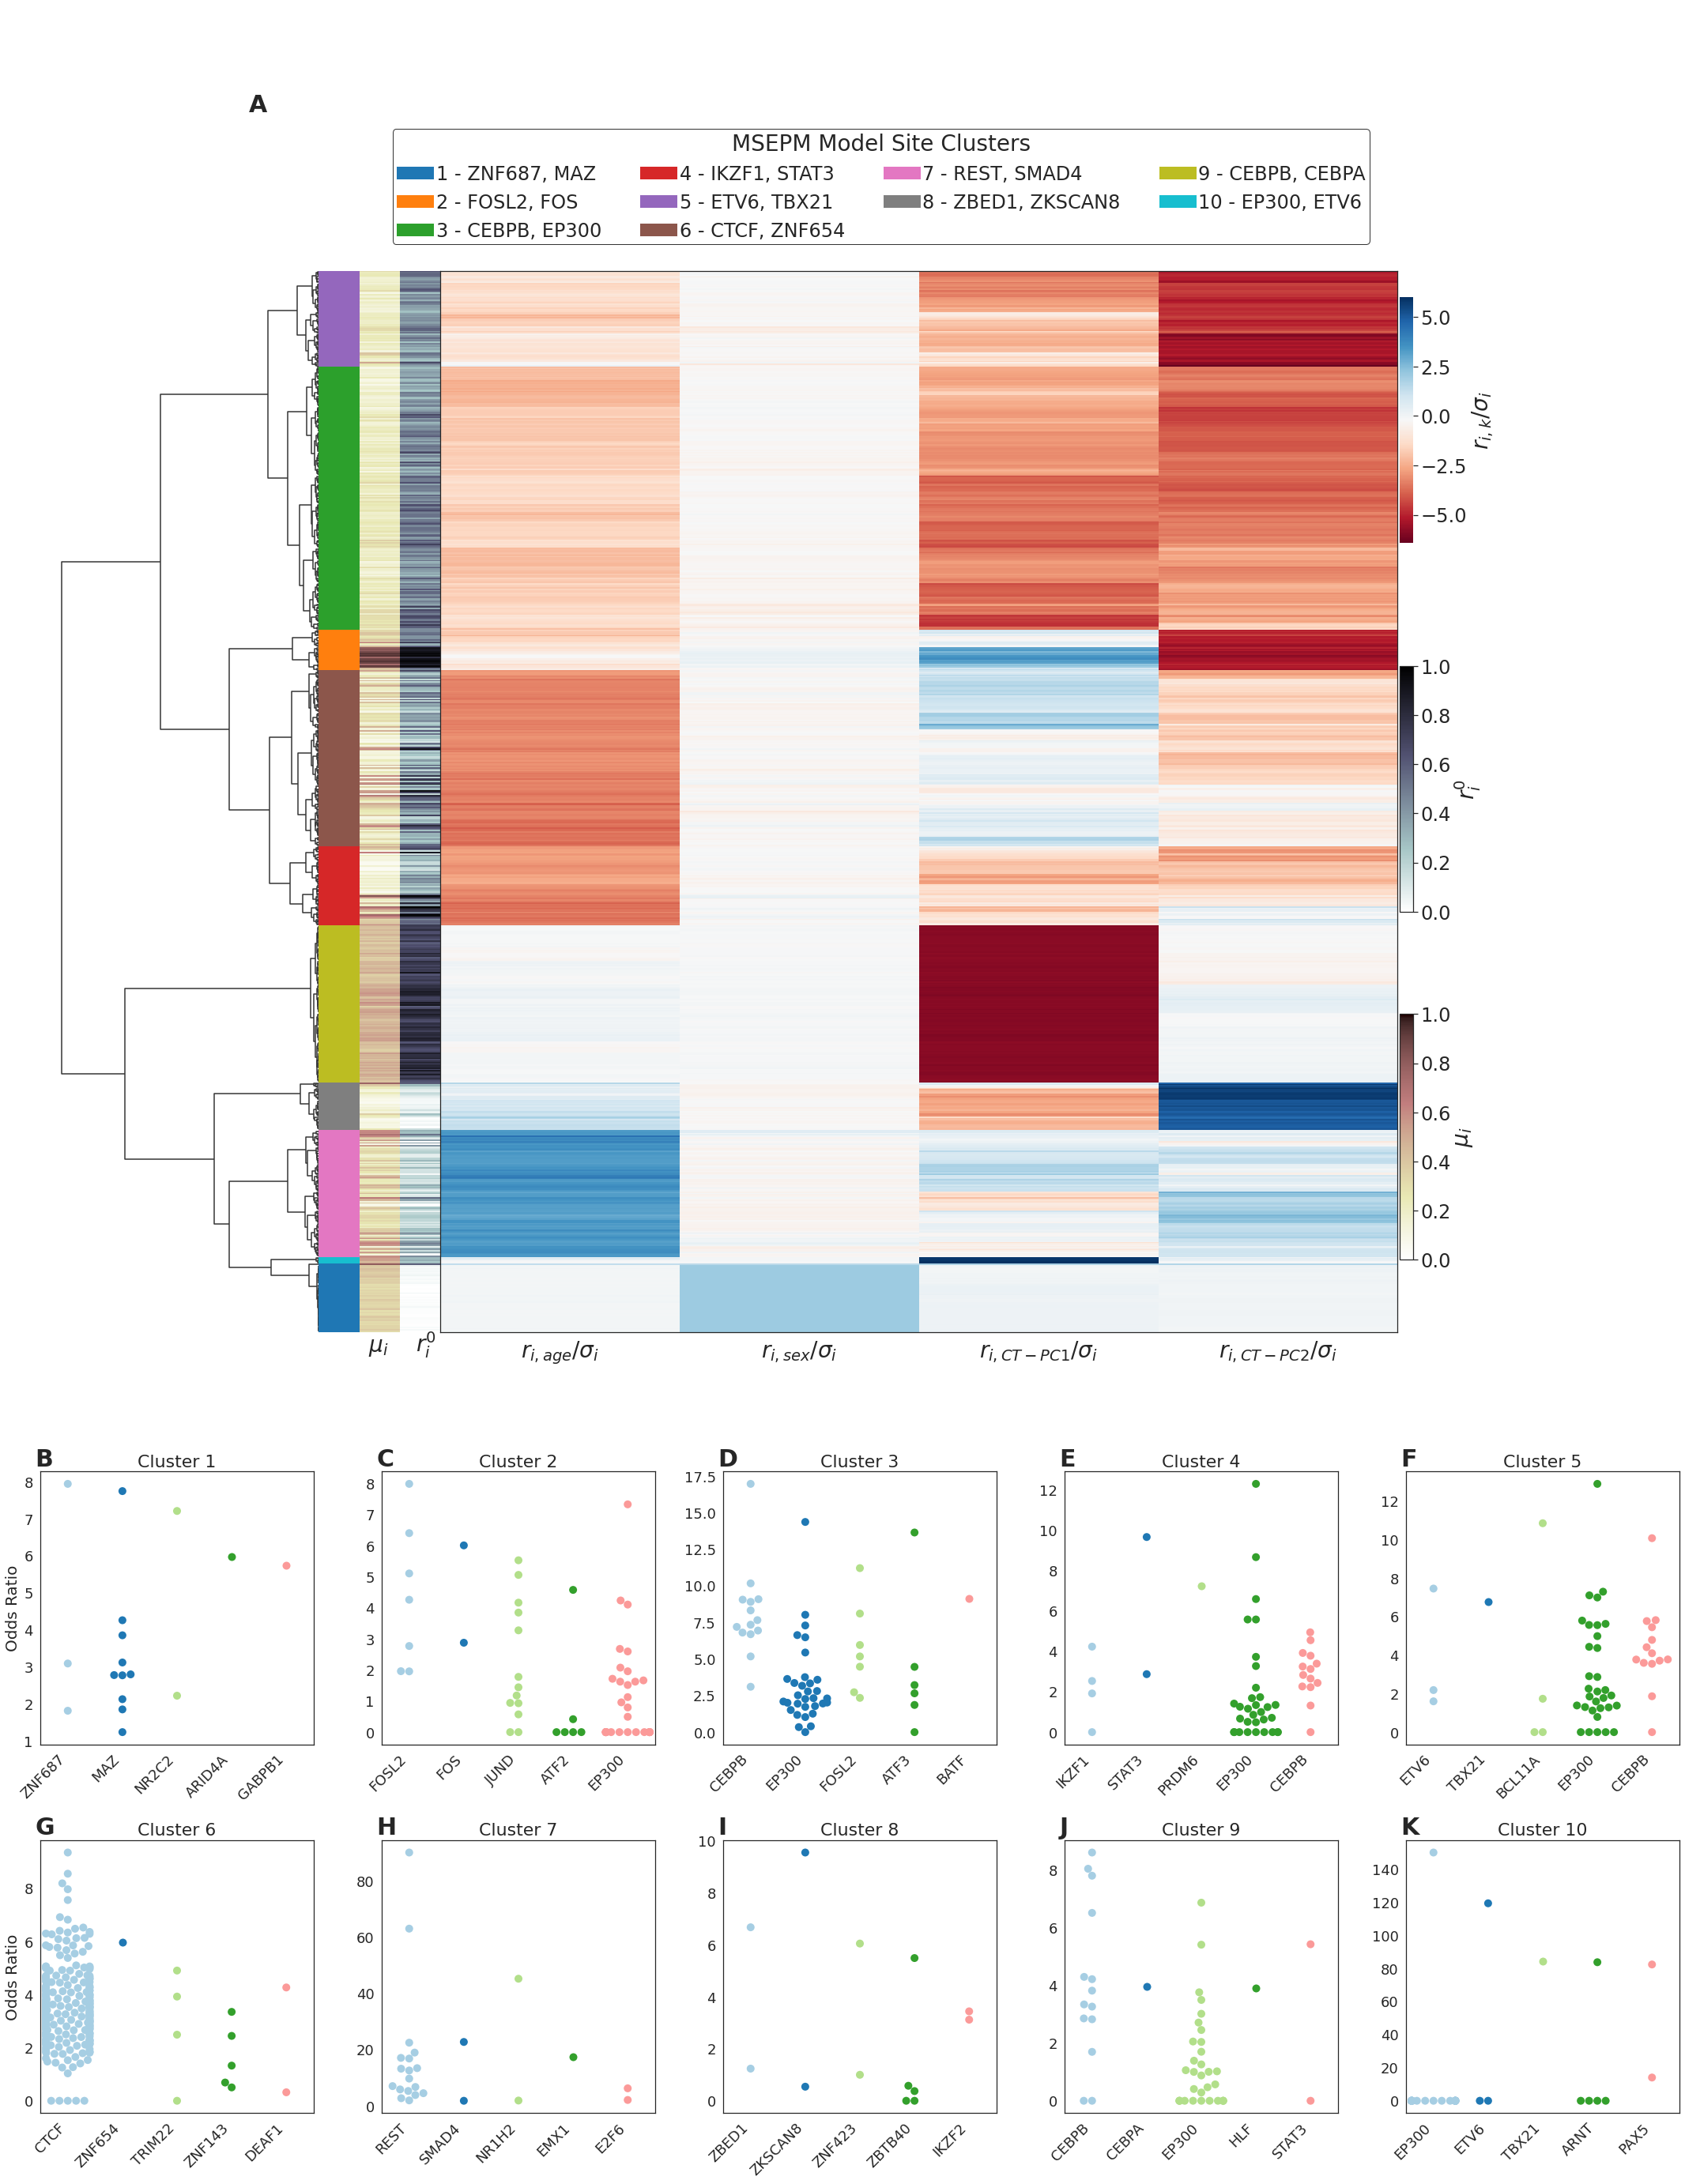

In [157]:
plot = sns.clustermap(full_model[standardized_labels].values, 
                      cmap='RdBu', col_cluster=False, row_linkage=coef_linkage, row_colors=[_colors, mean_meth_colors, meth_colors], 
                      figsize=(24,24), yticklabels=False, cbar_kws=dict(label='$r_{i,k} / \\sigma_{i}$'),
                      cbar_pos=(.995, 0.6, 0.01, 0.18), tree_kws=dict(linewidths=1.5))

plot.ax_heatmap.set(xticklabels=['$r_{i,age}/ \\sigma_{i}$','$r_{i,sex}/ \\sigma_{i}$',
                                 '$r_{i, CT-PC1}/ \\sigma_{i}$','$r_{i, CT-PC2}/ \\sigma_{i}$'])
plot.ax_heatmap.tick_params(axis='both', which='major', labelsize=28)
plot.ax_heatmap.figure.axes[-1].yaxis.label.set_size(28)
plot.ax_heatmap.figure.axes[-1].tick_params(labelsize=24)


    
handles = [Patch(facecolor=color) for color in cluster_colors]
legend = plt.legend(handles, [f'{x+1} - {top_tfs[x+1][0]}, {top_tfs[x+1][1]}' for x in cluster_labels], title='MSEPM Model Site Clusters',
                    bbox_to_anchor=(.98, .91), bbox_transform=plt.gcf().transFigure, 
                    ncol=4, frameon=True, borderpad=0.2, fontsize=24,
                    handletextpad=0.1, edgecolor='k', title_fontsize=28)    
    
for _, spine in plot.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.linewidth = 4
    
cbaxes = plot.fig.add_axes([.995, 0.33, 0.01, 0.18])  
cbar = plot.fig.colorbar(cm.ScalarMappable(cmap='bone_r'), cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel(f'$r^0_i$', fontsize=28)
cbar.ax.tick_params(labelsize=24)
plot.ax_heatmap.text(0.275, 0.0075, '$r^0_i$', 
                     fontsize=28, transform=plt.gcf().transFigure)

cbaxes = plot.fig.add_axes([.995, 0.075, 0.01, 0.18])  
cbar = plot.fig.colorbar(cm.ScalarMappable(cmap='pink_r'), cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel(f'$\mu_i$', fontsize=28)
cbar.ax.tick_params(labelsize=24)
plot.ax_heatmap.text(0.24, 0.008, '$\mu_i$', 
                     fontsize=28, transform=plt.gcf().transFigure)

plot.ax_heatmap.text(-.2, 1.15, 'A', fontsize=30, transform=plot.ax_heatmap.transAxes, weight='bold')


subplot_size = .2

fit_pos_y = [0, .25, .5, .75, 1]
fit_pos_x = [-.28, -.55]

fig_labels = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']

for count, clust in enumerate(cluster_labels):
    row = int(count / 5)
    col = count - row * 5
    ax = plot.fig.add_axes([fit_pos_y[col], fit_pos_x[row], subplot_size, subplot_size])
    clust_df = locResults.loc[locResults['userSet'] == clust + 1]
    #clust_df = clust_df.loc[clust_df['collection'] == 'encode_v4']
    ax.set_title(f'Cluster {clust +1}', fontsize=22)
    top_tf = plot_tf_enrichment(clust_df, ax, ranked_tf=5)
    top_tfs[count + 1] = top_tf
    if count == 0 or count == 5:
        ax.set_ylabel('Odds Ratio')
    ax.text(-.02, 1.02, fig_labels[count], fontsize=30, transform=ax.transAxes, weight='bold')



plt.savefig(os.path.join(wd, 'Paper/Figures/Figure5.png'), dpi=200, bbox_inches='tight')

plt.show()

### Supplemental ROC Curve for Sex Prediction

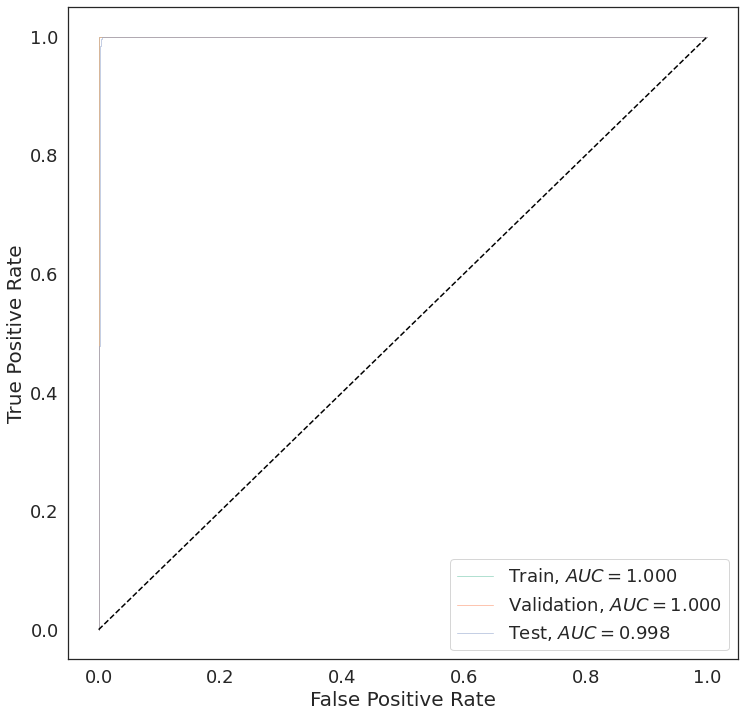

In [158]:
fig, ax = plt.subplots(figsize=(12,12))

model_labels = ['Train', 'Validation', 'Test']
model_colors = sns.color_palette("Set2")

for count, model in enumerate(['train', 'val', 'test']):
    ax.plot(epm_models["epm_4"][f'{model}_fpr'], 
            epm_models["epm_4"][f"{model}_tpr"],
            color=model_colors[count],
            lw=1,
            label=f'{model_labels[count]}, $AUC={epm_models["epm_4"][f"{model}_auc"]:.3f}$',
            alpha=.5
            )
ax.plot([0,1], [0,1], 'k--')
    
plt.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.show()